In this kernel I will do my EDA on the dataset, make some visualizations, try to find any insights and create some new features.

Join me, it promises to be a thrilling adventure.

Some tricks being used:
* [card1 count encoding](#1)
* [Covariate Shift](#2)
* [features interaction](#3)
* [data relaxation](#4)

New engineered features:
* [Number of NaNs](#5)
* [TransactionAmt and it's decimal part](#6)

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

/Users/adam/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Loading all datasets using multiprocessing. This speads up a process a bit.

In [2]:
DIR = "../../ieee-fraud-detection/"
files = [f'{DIR}test_identity.csv', 
         f'{DIR}test_transaction.csv',
         f'{DIR}train_identity.csv',
         f'{DIR}train_transaction.csv',
         f'{DIR}sample_submission.csv']

In [4]:
file = files[0]
data = pd.read_csv(file)

data.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id_09             ...                                 id_31  id_32  \
0    NaN             ...               chrome 67.0 for android    NaN   
1    0.0             ...               chrome 67.0 for android   24.0   
2    NaN             ...                    ie 11.0 for tablet    NaN   
3    0.0             ...               chrome 67.0 for android    NaN   
4    NaN             ...               chrome 67.0 for android    NaN   

      id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0       NaN             NaN      F     F     T      F      mobile   
1  1280x720  match_status:2      T     F     T      T      mobile   
2       NaN             NaN      F     T     T      F     desktop   
3       NaN             NaN      F     F     T      F      mobile   
4       NaN             NaN      F     F     T      F      mobile   

                    DeviceInfo  
0  MYA-L13 Build/HUAWEIMYA-L13  
1         LGLS676 Build/MXB48T  
2                  Trident/7.0  
3  MYA-L13 Build/HUAWEIMYA-L13  
4         SM-G9650 Build/R16NW  

[5 rows x 41 columns]

In [3]:
%%time
def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

CPU times: user 3.27 s, sys: 7.48 s, total: 10.7 s
Wall time: 47.9 s


In [4]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect();

In [5]:
def plot_numerical(feature):
    """
    Plot some information about a numerical feature for both train and test set.
    Args:
        feature (str): name of the column in DataFrame
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
    sns.kdeplot(train[feature], ax=axes[0][0], label='Train');
    sns.kdeplot(test[feature], ax=axes[0][0], label='Test');

    sns.kdeplot(train[train['isFraud']==0][feature], ax=axes[0][1], label='isFraud 0')
    sns.kdeplot(train[train['isFraud']==1][feature], ax=axes[0][1], label='isFraud 1')

    test[feature].index += len(train)
    axes[1][0].plot(train[feature], '.', label='Train');
    axes[1][0].plot(test[feature], '.', label='Test');
    axes[1][0].set_xlabel('row index');
    axes[1][0].legend()
    test[feature].index -= len(train)

    axes[1][1].plot(train[train['isFraud']==0][feature], '.', label='isFraud 0');
    axes[1][1].plot(train[train['isFraud']==1][feature], '.', label='isFraud 1');
    axes[1][1].set_xlabel('row index');
    axes[1][1].legend()

    pd.DataFrame({'train': [train[feature].isnull().sum()], 'test': [test[feature].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[2][0]);
    pd.DataFrame({'isFraud 0': [train[(train['isFraud']==0) & (train[feature].isnull())][feature].shape[0]],
                  'isFraud 1': [train[(train['isFraud']==1) & (train[feature].isnull())][feature].shape[0]]}).plot(kind='bar', rot=0, ax=axes[2][1]);

    fig.suptitle(feature, fontsize=18);
    axes[0][0].set_title('Train/Test KDE distribution');
    axes[0][1].set_title('Target value KDE distribution');
    axes[1][0].set_title('Index versus value: Train/Test distribution');
    axes[1][1].set_title('Index versus value: Target distribution');
    axes[2][0].set_title('Number of NaNs');
    axes[2][1].set_title('Target value distribution among NaN values');
    
# This code is stolen from Chris Deotte. 
def relax_data(df_train, df_test, col):
    cv1 = pd.DataFrame(df_train[col].value_counts().reset_index().rename({col:'train'},axis=1))
    cv2 = pd.DataFrame(df_test[col].value_counts().reset_index().rename({col:'test'},axis=1))
    cv3 = pd.merge(cv1,cv2,on='index',how='outer')
    factor = len(df_test)/len(df_train)
    cv3['train'].fillna(0,inplace=True)
    cv3['test'].fillna(0,inplace=True)
    cv3['remove'] = False
    cv3['remove'] = cv3['remove'] | (cv3['train'] < len(df_train)/10000)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] < cv3['test']/3)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] > 3*cv3['test'])
    cv3['new'] = cv3.apply(lambda x: x['index'] if x['remove']==False else 0,axis=1)
    cv3['new'],_ = cv3['new'].factorize(sort=True)
    cv3.set_index('index',inplace=True)
    cc = cv3['new'].to_dict()
    df_train[col] = df_train[col].map(cc)
    df_test[col] = df_test[col].map(cc)
    return df_train, df_test

# Transaction DT
According to the official description 'TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).' I see people in some kernels assume that a start date is a 1 of December 2017, but to be honest the exact start date is not that important. 

So lets transform TransactionDT into a datetime.

In [6]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

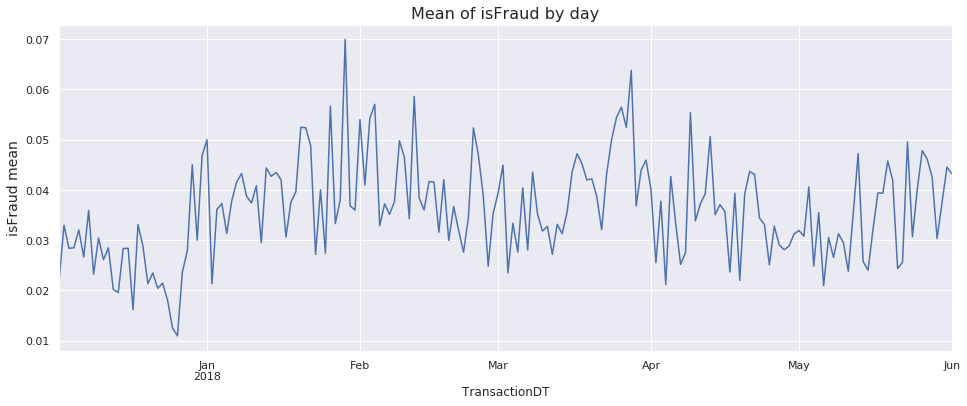

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by day', fontsize=16);

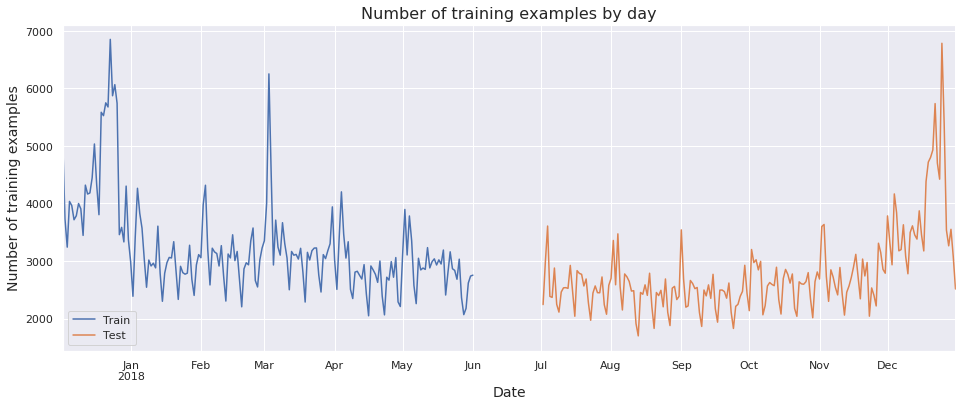

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of training examples', fontsize=14);
axes.set_title('Number of training examples by day', fontsize=16);
axes.legend(['Train', 'Test']);

And now combining both mean of isFraud by day and number of training examples by day into a single plot.

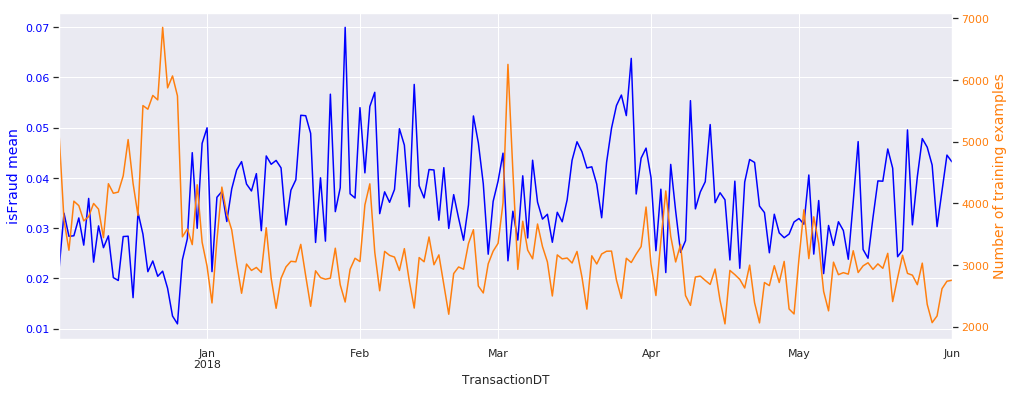

In [9]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean', color='blue', fontsize=14)
ax2 = ax1.twinx()
train['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=ax2, color='tab:orange');
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('Number of training examples', color='tab:orange', fontsize=14);
ax2.grid(False)

<a id="1"></a>
# card1
I have decided to start from one of the most important features of this dataset according to LightGBM feature_importance. And **card1** is one of those features.

What I did is I've created a separate dataset with only this feature in it and also I added one more feature to this new dataset, which is an original feature's frequency (count) encoding. Why I did this? Well, you can reference [Santander Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-transaction-prediction) competition, where this kind of encoding really boosted a score up. 

I'll make some visualizations (shoutout to [Chris Deotte](https://www.kaggle.com/cdeotte)) to show you why that works and might work in this case as well.

In [10]:
y = train['isFraud']
X = pd.DataFrame()
X['card1'] = train['card1']
X['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.548645816796713


So if we train a simple decision tree, using this two features we have an AUC slightly higher that 0.5. Let's see why by plotting this tree as a graph

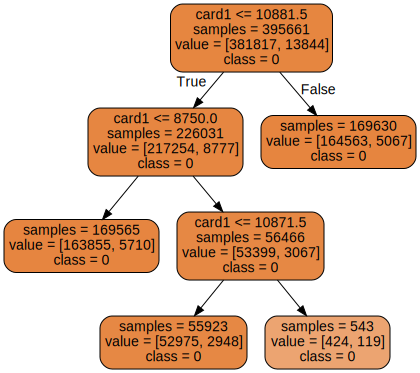

In [12]:
tree_graph = tree.export_graphviz(clf, out_file=None, max_depth = 10,
    impurity = False, feature_names = X.columns, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)

The first split is by the values less than or equal to 10881.5 (black line) and the second one is 8750.0 (red line) and a tree does not use a count feature at all.

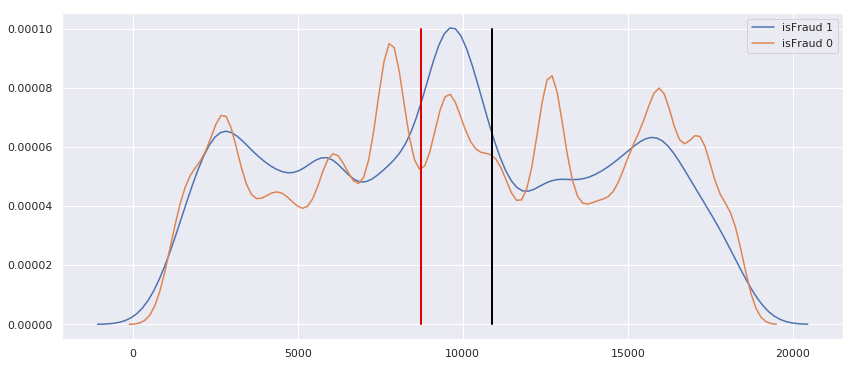

In [13]:
plt.figure(figsize=(14, 6))
sns.kdeplot(X[y==1]['card1'], label='isFraud 1');
sns.kdeplot(X[y==0]['card1'], label='isFraud 0');
plt.plot([10881.5, 10881.5], [0.0000, 0.0001], sns.xkcd_rgb["black"], lw=2);
plt.plot([8750.0, 8750.0], [0.0000, 0.0001], sns.xkcd_rgb["red"], lw=2);

But lets take a little step back and train a boosting model on only one original feature card1

In [14]:
params = {'objective': 'binary', "boosting_type": "gbdt", "subsample": 1, "bagging_seed": 11, "metric": 'auc', 'random_state': 47}
X_train, X_test, y_train, y_test = train_test_split(X['card1'], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train.values.reshape(-1, 1), y_train)
print('ROC AUC score', roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1]))

ROC AUC score 0.6929916198705168


This is a heatmap with a probability of isFraud=1 for every unique value in the **card1** feature.

This picture reminds me an opening from a Total Recall movie. 

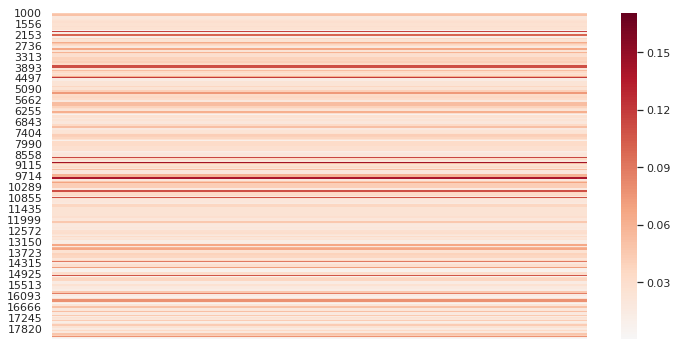

In [15]:
plt.figure(figsize=(12, 6))
x = clf.predict_proba(X['card1'].sort_values().unique().reshape(-1, 1))[:, 1]
x = pd.Series(x, index=X['card1'].sort_values().unique())
sns.heatmap(x.to_frame(), cmap='RdBu_r', center=0.0);
plt.xticks([]);

Now lets add a second feature - count encoded **card1** values.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7677377885485746


Holdout score has significantly increased. Lets create another heatmap and see why. 

There are some darker spots in some intersections of the variable **card1** values and it's count encoded values. This is the reason of the holdout score improvement.

*The image is pre-rendered since rendering takes some significant amount of time*

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1696976%2F7153f1242daa586d6849c83242c3fe40%2F35267aee89a7552caf082b6bb0039aa5-full.png?generation=1564585074348507&alt=media)

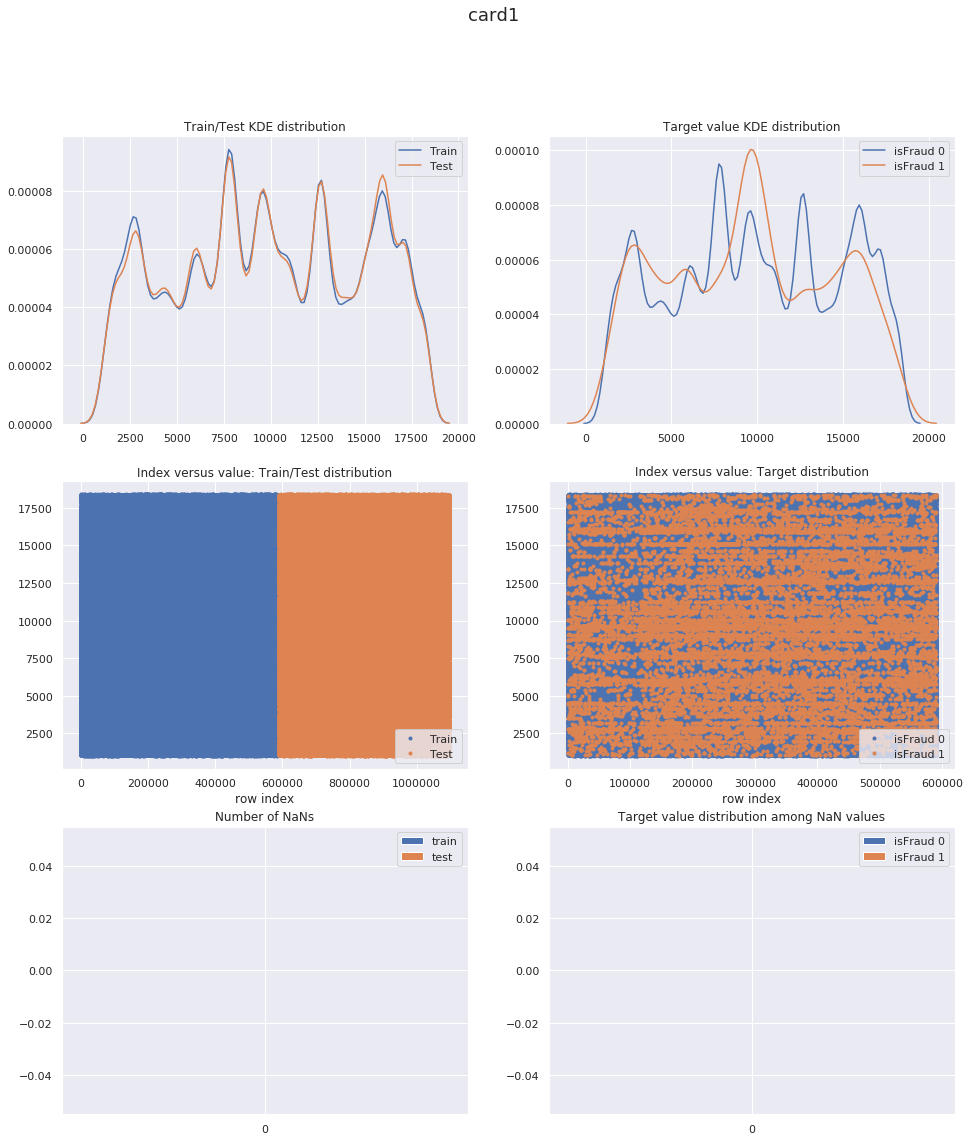

In [17]:
plot_numerical('card1')

Plotting this variable gives us such information as:
* distribution in train and test set is almost equal.
* distribution between target values differs, which make this feature so valuable
* this feature doesn't have any NaNs

<a id="2"></a>
Lets check a Covariate Shift of the feature. This means that we will try to distinguish whether a values correspond to a training set or to a testing set.

In [18]:
def covariate_shift(feature):
    df_card1_train = pd.DataFrame(data={feature: train[feature], 'isTest': 0})
    df_card1_test = pd.DataFrame(data={feature: test[feature], 'isTest': 1})

    # Creating a single dataframe
    df = pd.concat([df_card1_train, df_card1_test], ignore_index=True)
    
    # Encoding if feature is categorical
    if str(df[feature].dtype) in ['object', 'category']:
        df[feature] = LabelEncoder().fit_transform(df[feature].astype(str))
    
    # Splitting it to a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(df[feature], df['isTest'], test_size=0.33, random_state=47, stratify=df['isTest'])

    clf = lgb.LGBMClassifier(**params, num_boost_round=500)
    clf.fit(X_train.values.reshape(-1, 1), y_train)
    roc_auc =  roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

    del df, X_train, y_train, X_test, y_test
    gc.collect();
    
    return roc_auc

In [19]:
print('Covariate Shift ROC AUC score:', covariate_shift('card1'))

Covariate Shift ROC AUC score: 0.5396478567335838


ROC AUC score is close to 0.5, this means that this feature almost does not have any shift between train and test and is definitely worth keeping it.

# ProductCD

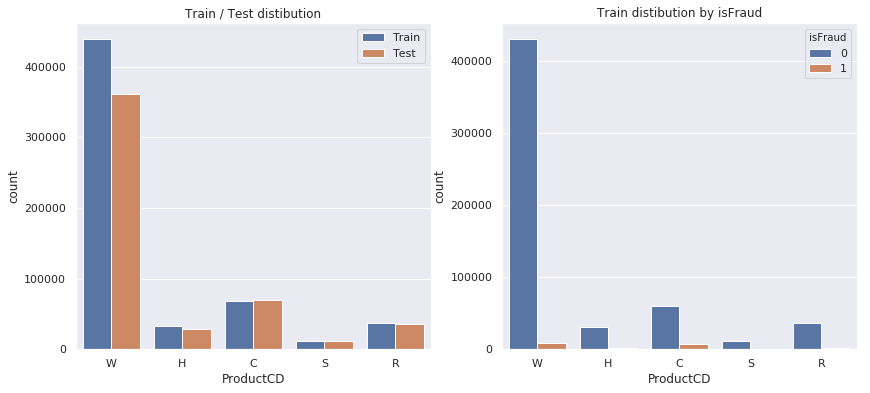

In [20]:
df_train = pd.DataFrame(data={'ProductCD': train['ProductCD'], 'isTest': 0})
df_test = pd.DataFrame(data={'ProductCD': test['ProductCD'], 'isTest': 1})
df = pd.concat([df_train, df_test], ignore_index=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(data=df.fillna('NaN'), x='ProductCD', hue='isTest', ax=axes[0]);
sns.countplot(data=train[['ProductCD', 'isFraud']].fillna('NaN'), x='ProductCD', hue='isFraud', ax=axes[1]);
axes[0].set_title('Train / Test distibution');
axes[1].set_title('Train distibution by isFraud');
axes[0].legend(['Train', 'Test']);

In [21]:
print('Covariate shift ROC AUC:', covariate_shift('ProductCD'))

Covariate shift ROC AUC: 0.5175898744813954


# card2

Making a count feature for card2 to perform the same experiment as with card1. First the heatmap for all possible interactions of card2 feature and it's count.

In [22]:
y = train['isFraud']
X = pd.DataFrame()
X['card2'] = train['card2']
X['card2_count'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

result_df = pd.DataFrame()

for i in X['card2'].sort_values().unique():
    x = pd.DataFrame()
    x['card2'] = [i] * X['card2_count'].nunique()
    x['card2_count'] = X['card2_count'].sort_values().unique()
    
    result_df = pd.concat([result_df, x], axis=0)

ROC AUC score: 0.7434718581403965


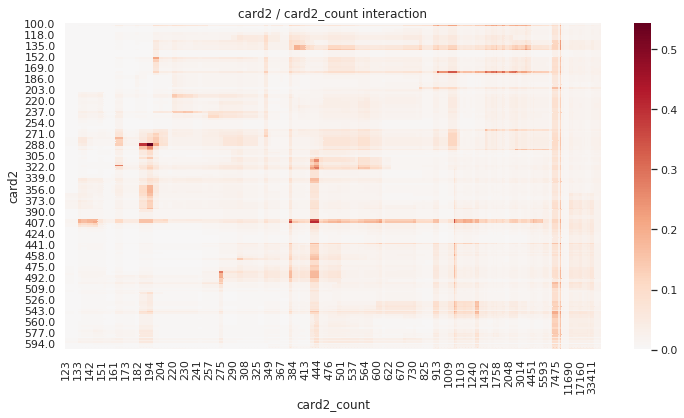

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

preds = clf.predict_proba(result_df)[:, 1]
preds = preds.reshape(X['card2'].nunique(dropna=False), X['card2_count'].nunique(dropna=False))
preds = pd.DataFrame(preds, index=X['card2'].sort_values().unique(), columns=X['card2_count'].sort_values().unique())

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.heatmap(preds, cmap='RdBu_r', center=0.0);
ax.set_ylabel('card2');
ax.set_xlabel('card2_count');
ax.set_title('card2 / card2_count interaction');

And a scatter plot with a "decision boundary" of the model. White 'X' marks represents a test set examples.

In [24]:
test_X = pd.DataFrame()
test_X['card2'] = test['card2']
test_X['card2_count'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

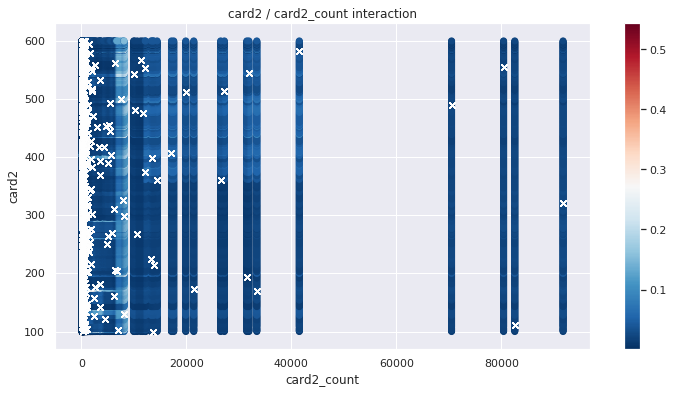

In [25]:
plt.figure(figsize=(12, 6))
ax = plt.axes()
sc = plt.scatter(y=result_df['card2'], x=result_df['card2_count'], c=clf.predict_proba(result_df)[:, 1], cmap='RdBu_r');
ax.set_ylabel('card2');
ax.set_xlabel('card2_count');
ax.set_title('card2 / card2_count interaction');
plt.colorbar(sc);
plt.scatter(y=test_X['card2'], x=test_X['card2_count'], marker='x', c='white', alpha=0.5);

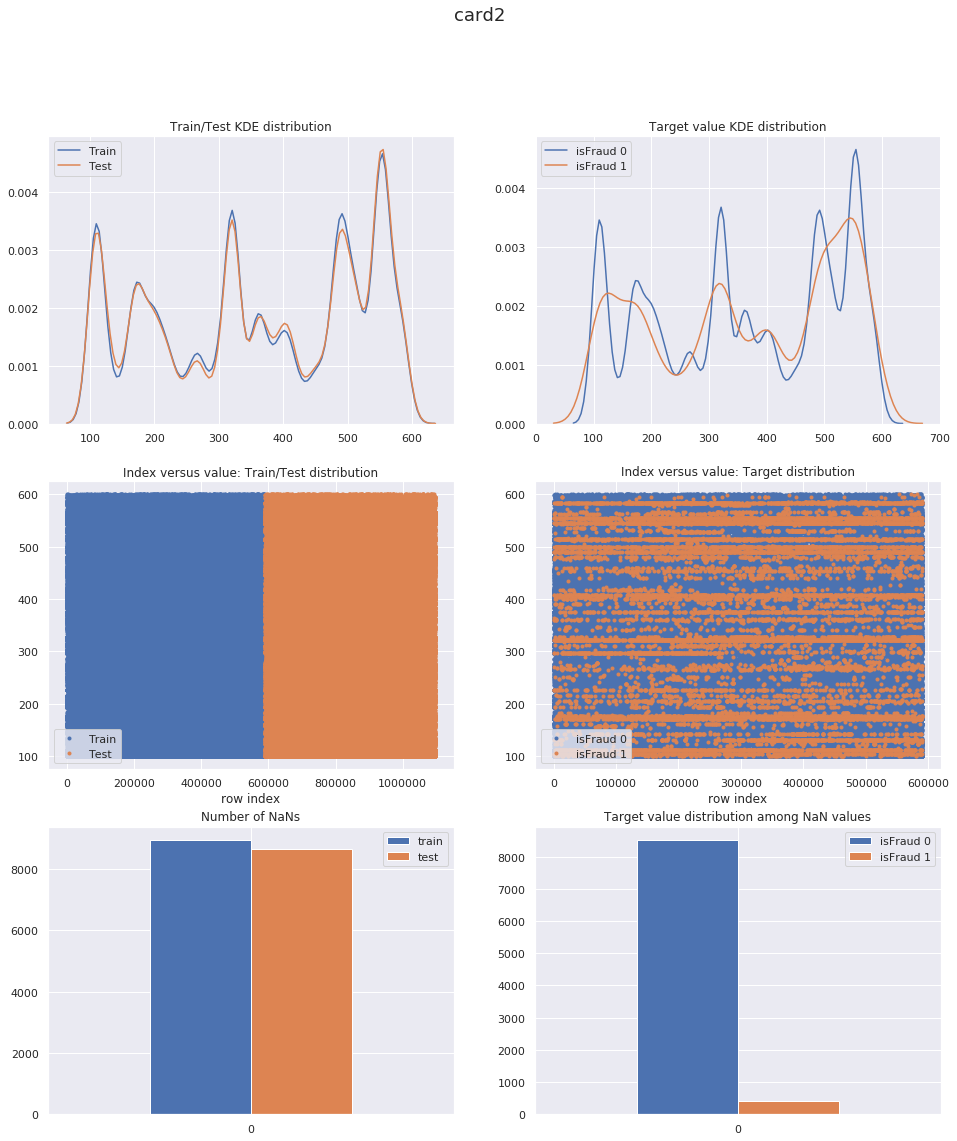

In [26]:
plot_numerical('card2')

In [27]:
print('Covariate shift ROC AUC:', covariate_shift('card2'))

Covariate shift ROC AUC: 0.5437263744083236


# card3

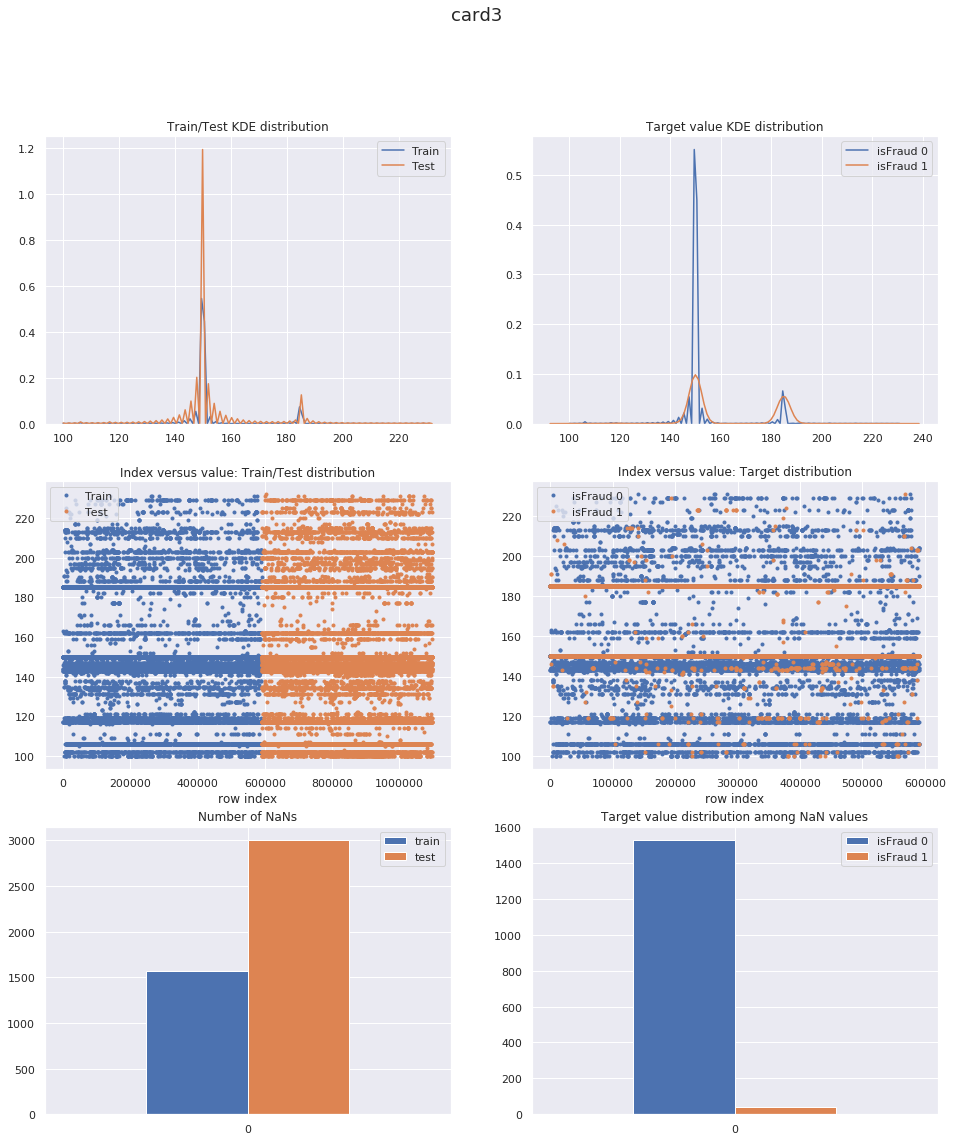

In [28]:
plot_numerical('card3')

In [29]:
print('Covariate shift ROC AUC:', covariate_shift('card3'))

Covariate shift ROC AUC: 0.5124625896689979


# card4

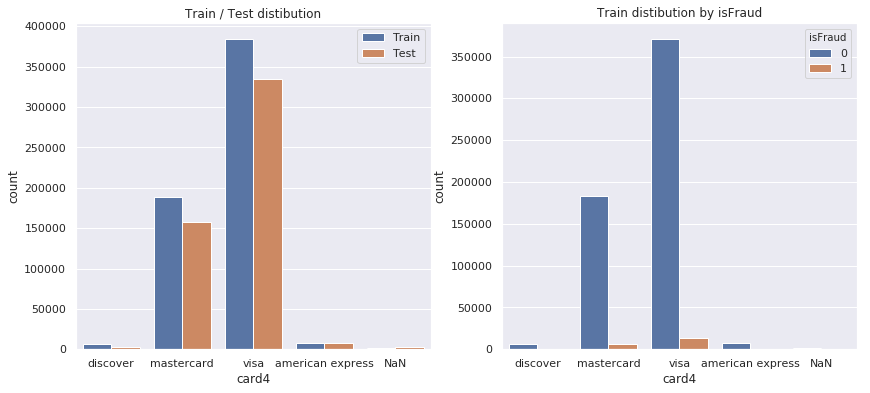

In [30]:
df_train = pd.DataFrame(data={'card4': train['card4'], 'isTest': 0})
df_test = pd.DataFrame(data={'card4': test['card4'], 'isTest': 1})
df = pd.concat([df_train, df_test], ignore_index=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(data=df.fillna('NaN'), x='card4', hue='isTest', ax=axes[0]);
sns.countplot(data=train[['card4', 'isFraud']].fillna('NaN'), x='card4', hue='isFraud', ax=axes[1]);
axes[0].set_title('Train / Test distibution');
axes[1].set_title('Train distibution by isFraud');
axes[0].legend(['Train', 'Test']);

In [31]:
print('Covariate shift ROC AUC:', covariate_shift('card4'))

Covariate shift ROC AUC: 0.5091414160089398


# card5

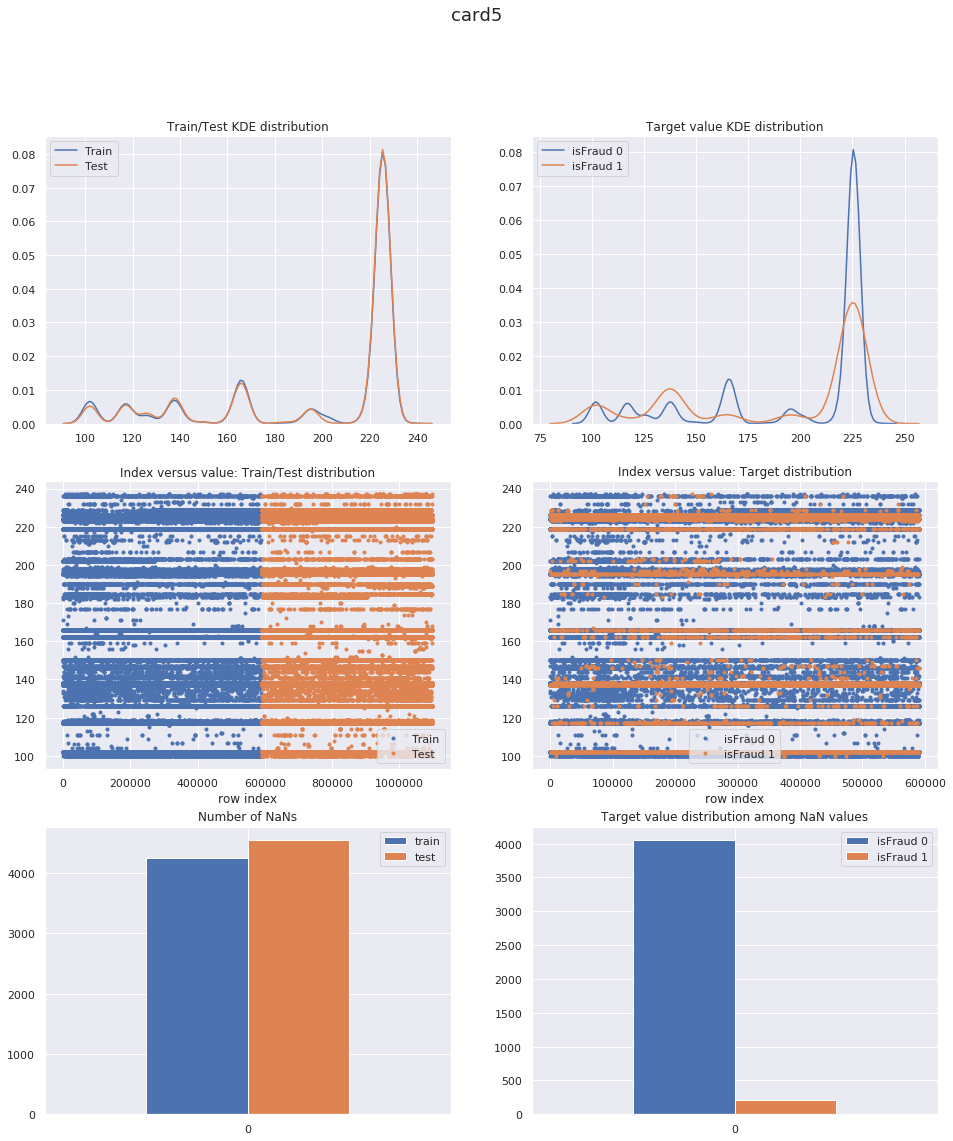

In [32]:
plot_numerical('card5')

In [33]:
print('Covariate shift ROC AUC:', covariate_shift('card5'))

Covariate shift ROC AUC: 0.5304401559074056


# card6

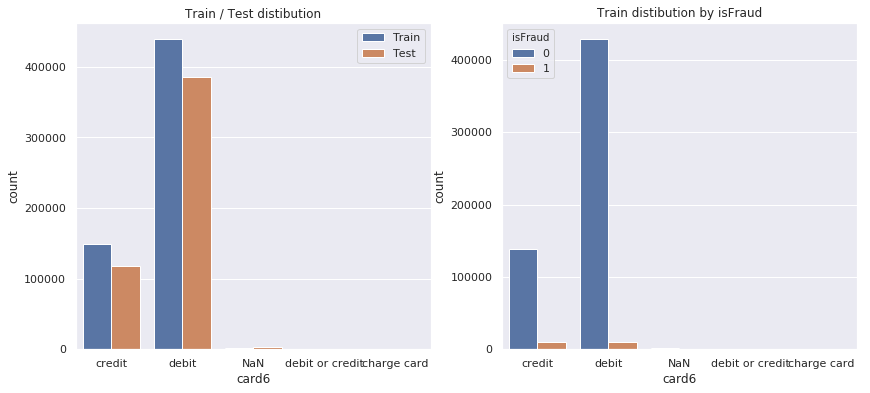

In [34]:
df_train = pd.DataFrame(data={'card6': train['card6'], 'isTest': 0})
df_test = pd.DataFrame(data={'card6': test['card6'], 'isTest': 1})
df = pd.concat([df_train, df_test], ignore_index=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(data=df.fillna('NaN'), x='card6', hue='isTest', ax=axes[0]);
sns.countplot(data=train[['card6', 'isFraud']].fillna('NaN'), x='card6', hue='isFraud', ax=axes[1]);
axes[0].set_title('Train / Test distibution');
axes[1].set_title('Train distibution by isFraud');
axes[0].legend(['Train', 'Test']);

In [35]:
print('Covariate shift ROC AUC:', covariate_shift('card6'))

Covariate shift ROC AUC: 0.5108433093974588


# addr1 

Another feature with a relatively high importance is **addr1**. According to the name of the feature we can assume that it contains some kind of users address, but in an encoded way. Also this time a feature have some missing values. We are going to fill them with 0.

In [36]:
y = train['isFraud']
X = pd.DataFrame()
X['addr1'] = train['addr1']
X['addr1_count'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
X['addr1'].fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X['addr1'], y, test_size=0.33, random_state=47)
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(X_train.values.reshape(-1, 1), y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1]))

ROC AUC score: 0.6384265775760748


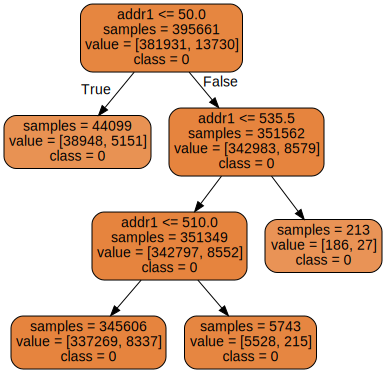

In [37]:
tree_graph = tree.export_graphviz(clf, out_file=None, max_depth = 10,
    impurity = False, feature_names = ['addr1'], class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)

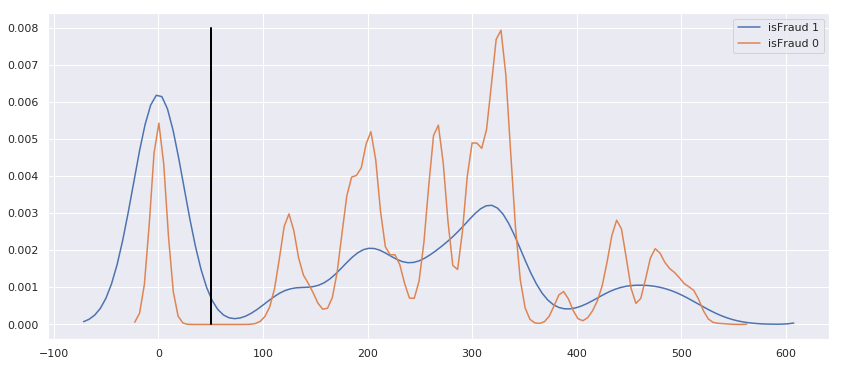

In [38]:
plt.figure(figsize=(14, 6))
sns.kdeplot(X[y==1]['addr1'], label='isFraud 1');
sns.kdeplot(X[y==0]['addr1'], label='isFraud 0');
plt.plot([50.0, 50.0], [0.0000, 0.008], sns.xkcd_rgb["black"], lw=2);

Again training a gradient boosting model with only one feature.

In [39]:
params = {'objective': 'binary', "boosting_type": "gbdt", "subsample": 1, "bagging_seed": 11, "metric": 'auc', 'random_state': 47}
X_train, X_test, y_train, y_test = train_test_split(X['addr1'], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train.values.reshape(-1, 1), y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1]))

ROC AUC score: 0.6855464245988521


Predictions heatmap.

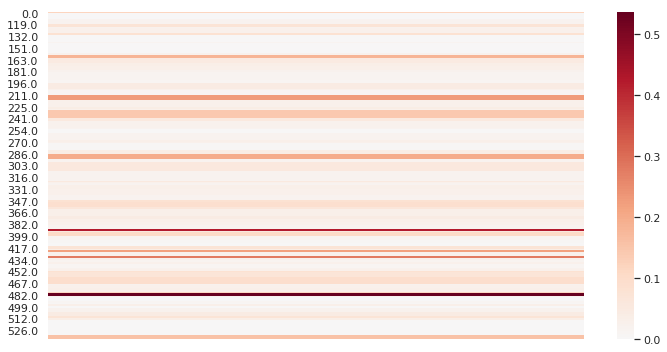

In [40]:
plt.figure(figsize=(12, 6))
x = clf.predict_proba(X['addr1'].sort_values().unique().reshape(-1, 1))[:, 1]
x = pd.Series(x, index=X['addr1'].sort_values().unique())
sns.heatmap(x.to_frame(), cmap='RdBu_r', center=0.0);
plt.xticks([]);

So far we are doing exactly the same thing that we have been doing for the previous variable.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.68584123437748


In [42]:
result_df = pd.DataFrame()

for i in X['addr1'].sort_values().unique():
    x = pd.DataFrame()
    x['addr1'] = [i] * X['addr1_count'].nunique()
    x['addr1_count'] = X['addr1_count'].sort_values().unique()
    
    result_df = pd.concat([result_df, x], axis=0)

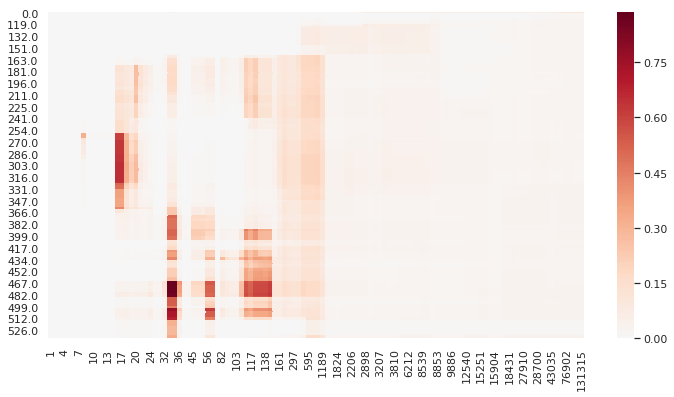

In [43]:
preds = clf.predict_proba(result_df)[:, 1]
preds = preds.reshape(X['addr1'].nunique(), X['addr1_count'].nunique())
preds = pd.DataFrame(preds, index=X['addr1'].sort_values().unique(), columns=X['addr1_count'].sort_values().unique())

plt.figure(figsize=(12, 6))
sns.heatmap(preds, cmap='RdBu_r', center=0.0);

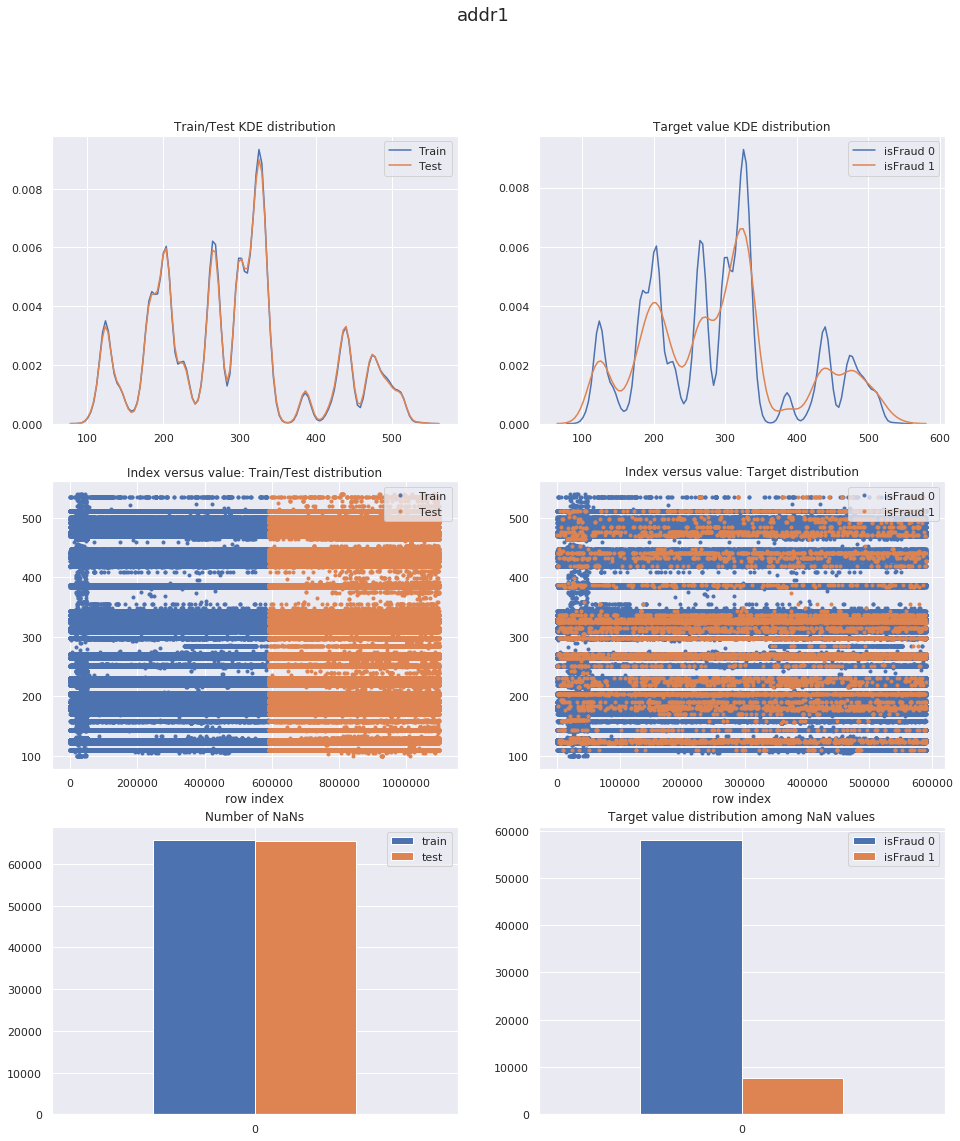

In [44]:
plot_numerical('addr1')

Distribution is the same, amount of NaN's is the same. Some difference in target value distribution. 

Next checking Covariate Shift for addr1.

In [45]:
print('Covariate shift ROC AUC score:', covariate_shift('addr1'))

Covariate shift ROC AUC score: 0.5216072351375447


ROC AUC score is close to 0.5

This feature also does not have any shift between train and test set.

<a id="3"></a>
# card1 to addr1 interaction

Next I am going to create a new feature out of this two features interaction and train on the result.

In [46]:
X = pd.DataFrame()
X['addr1'] = train['addr1']
X['card1'] = train['card1']
y = train['isFraud']
X['addr1'].fillna(0, inplace=True)

X['addr1_card1'] = X['addr1'].astype(str) + '_' + X['card1'].astype(str)
X['addr1_card1'] = LabelEncoder().fit_transform(X['addr1_card1'])

First training a model only using this two features, without their interaction.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X[['addr1', 'card1']], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.784380872912713


And now WITH interaction

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X[['addr1', 'card1', 'addr1_card1']], y, test_size=0.33, random_state=47, stratify=y)
clf1 = lgb.LGBMClassifier(**params)
clf1.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf1.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7868034424617317


In [49]:
result_df = pd.DataFrame()

for i in tqdm_notebook(X['addr1'].sort_values().unique()):
    x = pd.DataFrame()
    x['addr1'] = [i] * X['card1'].nunique()
    x['card1'] = X['card1'].sort_values().unique()
    
    result_df = pd.concat([result_df, x], axis=0)

Predictions heatmap of the two features interaction.

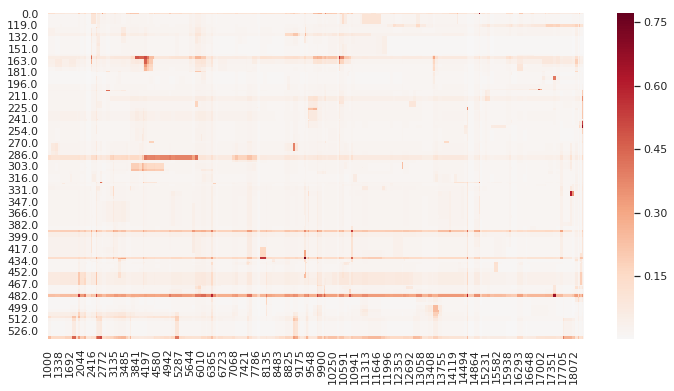

In [50]:
preds = clf.predict_proba(result_df)[:, 1]
preds = preds.reshape(X['addr1'].nunique(), X['card1'].nunique())
preds = pd.DataFrame(preds, index=X['addr1'].sort_values().unique(), columns=X['card1'].sort_values().unique())
plt.figure(figsize=(12, 6))
sns.heatmap(preds, cmap='RdBu_r', center=0.0);

Finally adding count features, so all in all we have 5 features

In [51]:
X['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
X['addr1_count'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.8079847404025295


<a id="5"></a>
# New feature: number of NaN's
We have plenty of NaN's in this dataset and they can have a significant effect so why don't we use them?
I am adding a new column to the dateset, which will contain a number of NaN for each row. So if a row (a single training example) contain, say, 10 NaNs, a new feature's value for this row will be 10.

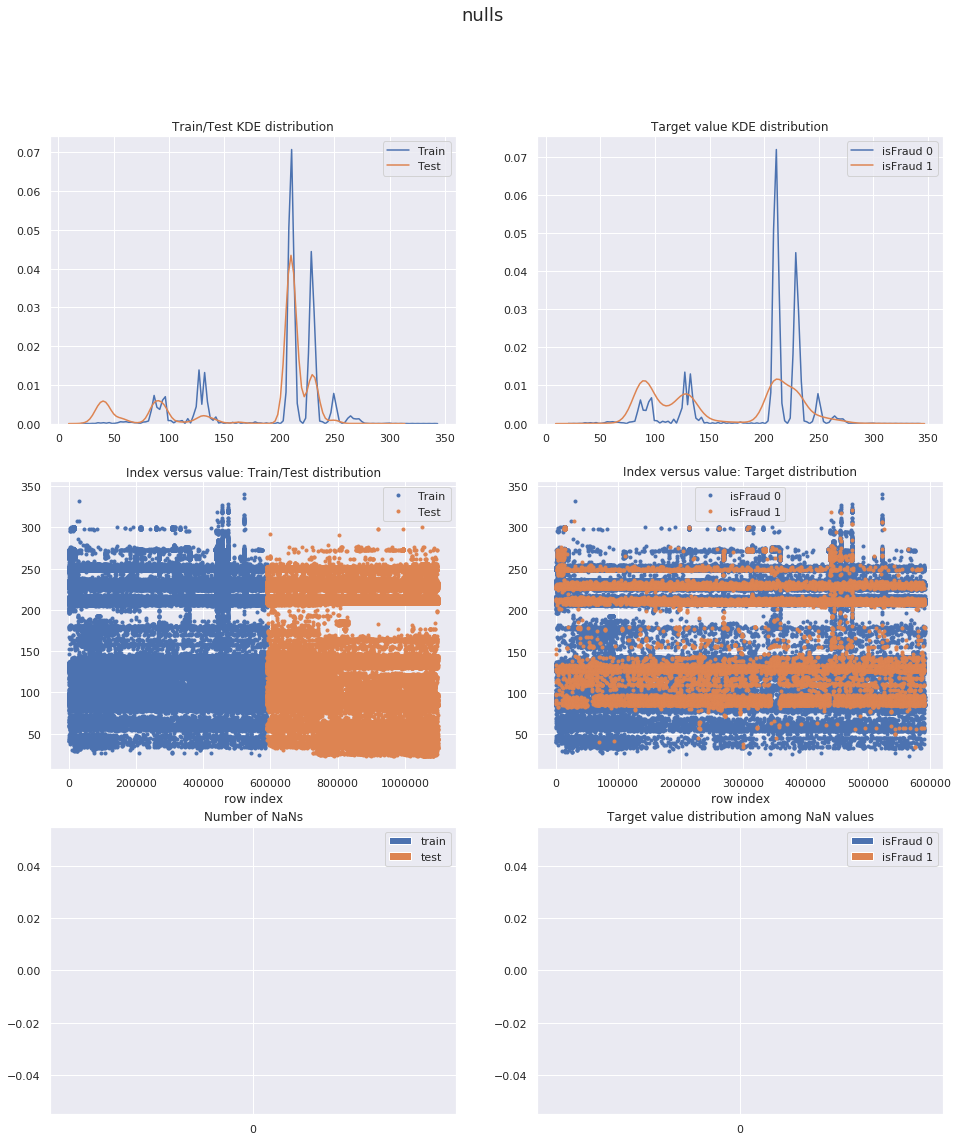

In [53]:
train['nulls'] = train.isnull().sum(axis=1)
test['nulls'] = test.isnull().sum(axis=1)
plot_numerical('nulls')

In [54]:
print('Covariant shift ROC AUC:', covariate_shift('nulls'))

Covariant shift ROC AUC: 0.690769942059486


We can see that this feature might be useful, but also keep in mind that covatiate shift is almost 0.7, which tells us that the distribution between train and test set has some difference.

<a id="6"></a>
# TransactionAmt and it's decimal part

First let's take a look at TransactionAmt feature and them I will create a new one - it's decimal part, which is a very popular way of creating a new features.

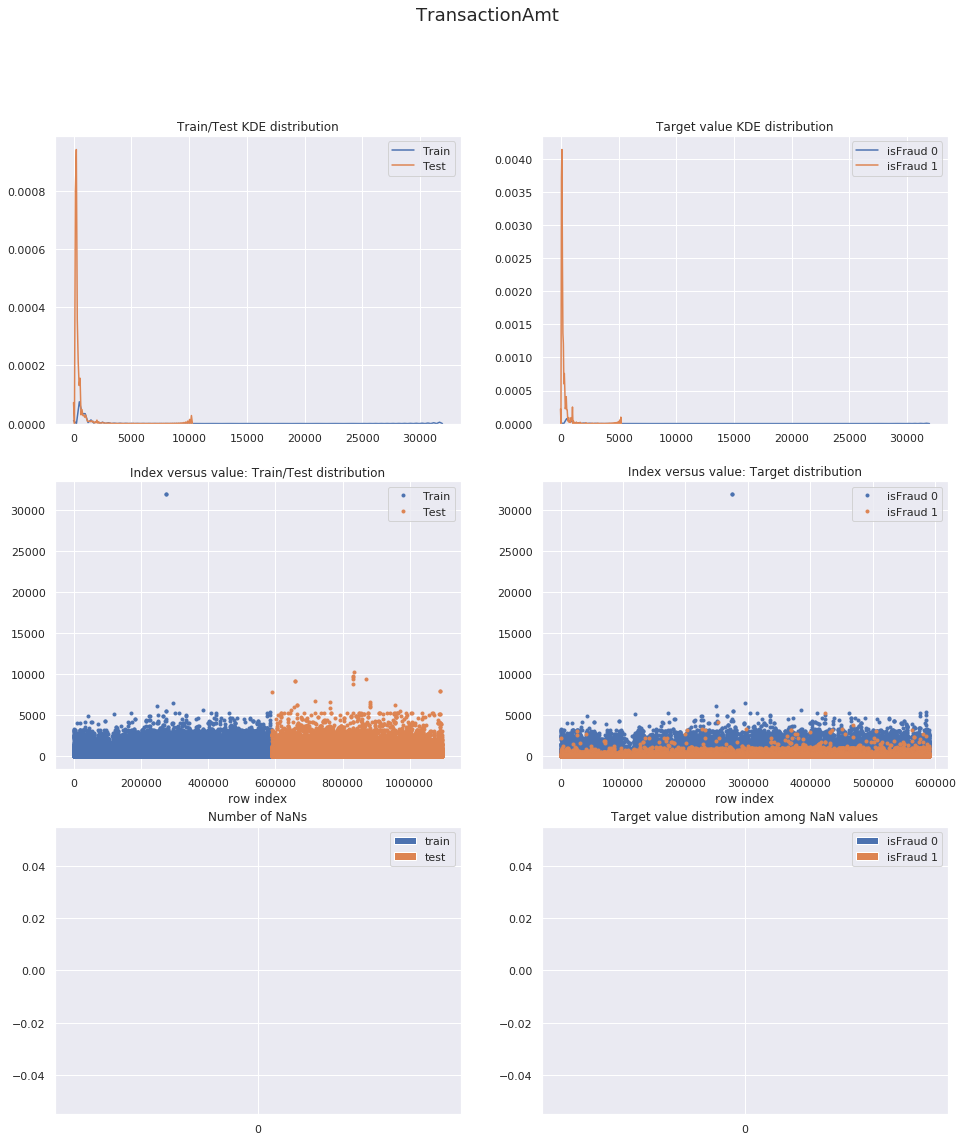

In [55]:
plot_numerical('TransactionAmt')

Moving average for TransactionAmt over time.

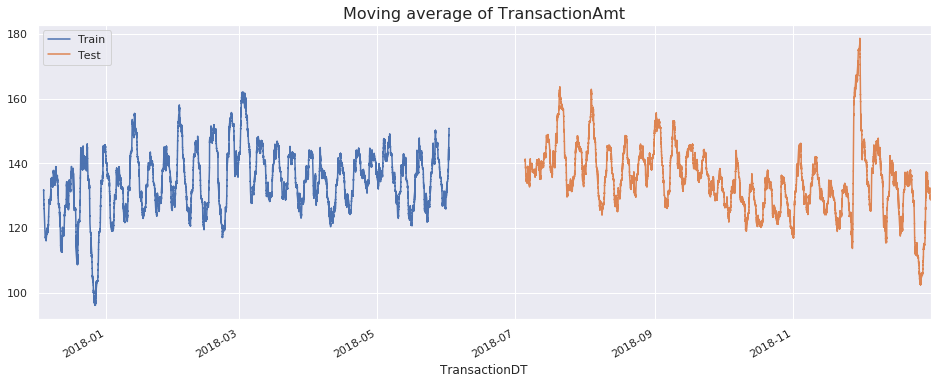

In [56]:
fig, axes = plt.subplots(1,1,figsize=(16, 6))
axes.set_title('Moving average of TransactionAmt', fontsize=16);
train[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes);
test[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes);
axes.legend(['Train', 'Test']);

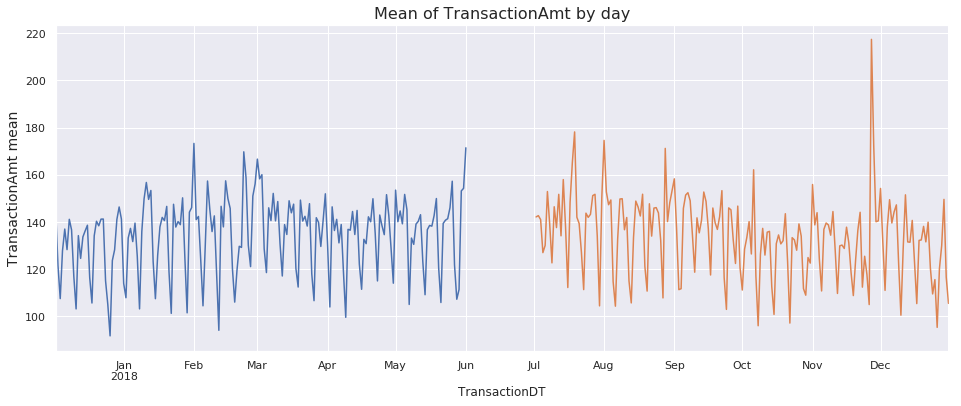

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes).set_ylabel('TransactionAmt mean', fontsize=14);
test.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes).set_ylabel('TransactionAmt mean', fontsize=14);
axes.set_title('Mean of TransactionAmt by day', fontsize=16);

A relationship between mean of TransactionAmt by day and a mean of isFraud by day.

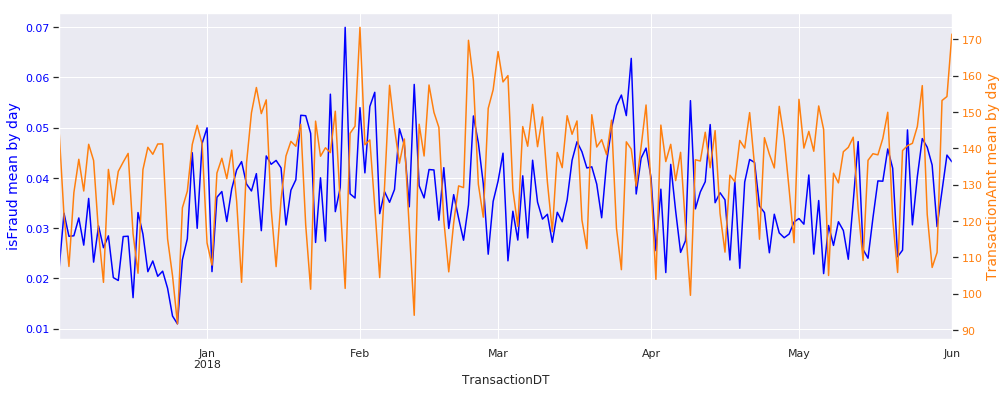

In [58]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean by day', color='blue', fontsize=14)
ax2 = ax1.twinx()
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=ax2, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('TransactionAmt mean by day', color='tab:orange', fontsize=14);
ax2.grid(False)

Decimal part of transaction amount.

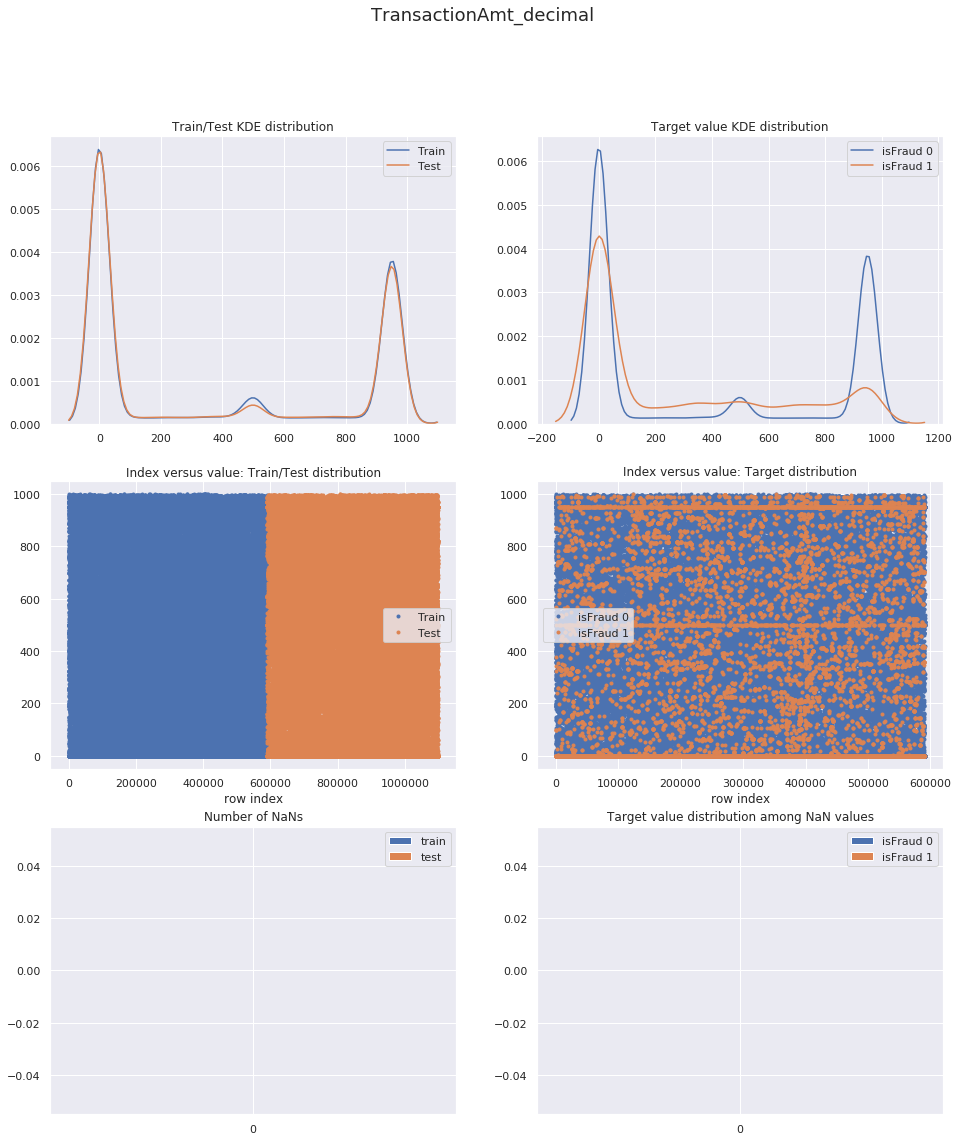

In [59]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)
plot_numerical('TransactionAmt_decimal')

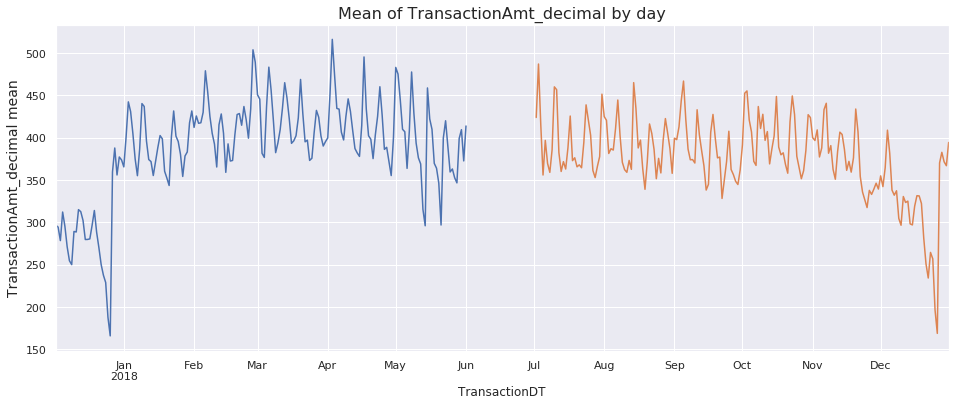

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt_decimal'].plot(ax=axes).set_ylabel('TransactionAmt_decimal mean', fontsize=14);
test.set_index('TransactionDT').resample('D').mean()['TransactionAmt_decimal'].plot(ax=axes).set_ylabel('TransactionAmt_decimal mean', fontsize=14);
axes.set_title('Mean of TransactionAmt_decimal by day', fontsize=16);

A relationship between mean of TransactionAmt_decimal by day and a mean of isFraud by day.

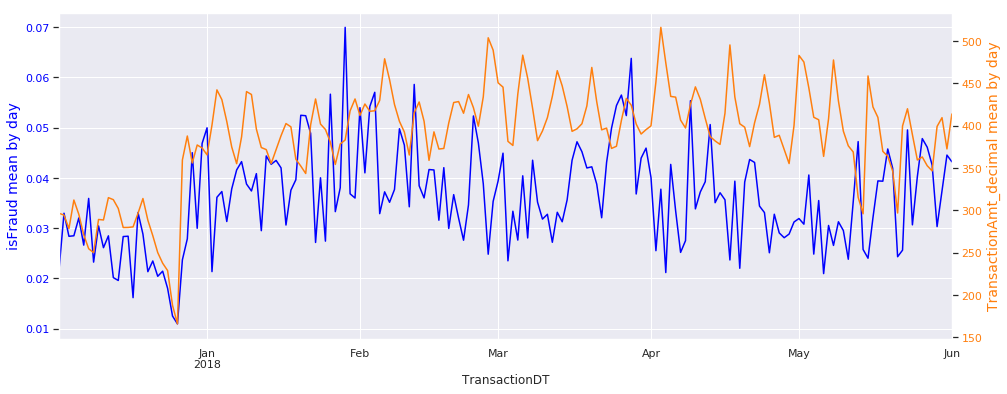

In [61]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean by day', color='blue', fontsize=14)
ax2 = ax1.twinx()
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt_decimal'].plot(ax=ax2, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('TransactionAmt_decimal mean by day', color='tab:orange', fontsize=14);
ax2.grid(False)

Lenght of the decimal part of transaction amount. What does it mean? Well, if lenght is 1 or 2 signs it is totaly understandable - there might be cents. But what is wrong with a decimal part's lenght being 3 and more sings? Maybe it is due to a currency convertion?

In [62]:
train['TransactionAmt_decimal_lenght'] = train['TransactionAmt'].astype(str).str.split('.', expand=True)[1].str.len()
test['TransactionAmt_decimal_lenght'] = test['TransactionAmt'].astype(str).str.split('.', expand=True)[1].str.len()

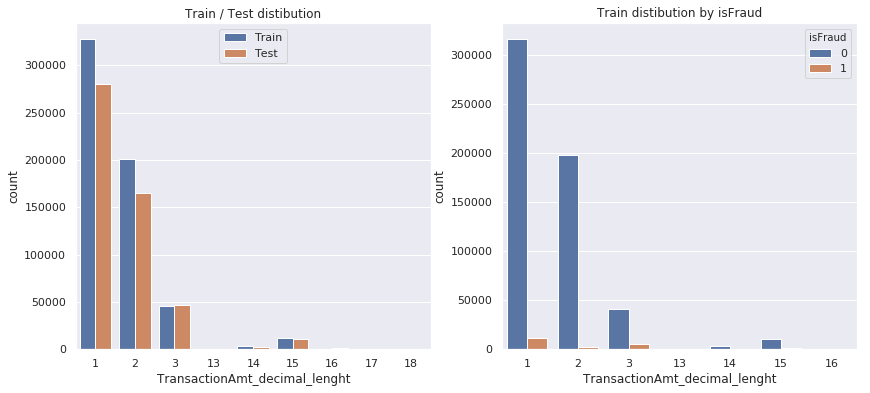

In [63]:
df_train = pd.DataFrame(data={'TransactionAmt_decimal_lenght': train['TransactionAmt_decimal_lenght'], 'isTest': 0})
df_test = pd.DataFrame(data={'TransactionAmt_decimal_lenght': test['TransactionAmt_decimal_lenght'], 'isTest': 1})
df = pd.concat([df_train, df_test], ignore_index=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(data=df.fillna('NaN'), x='TransactionAmt_decimal_lenght', hue='isTest', ax=axes[0]);
sns.countplot(data=train[['TransactionAmt_decimal_lenght', 'isFraud']].fillna('NaN'), x='TransactionAmt_decimal_lenght', hue='isFraud', ax=axes[1]);
axes[0].set_title('Train / Test distibution');
axes[1].set_title('Train distibution by isFraud');
axes[0].legend(['Train', 'Test']);

Covariate shift for all 3 features.

In [64]:
print('Covariant shift ROC AUC:', covariate_shift('TransactionAmt'))

Covariant shift ROC AUC: 0.5355514697281134


In [65]:
print('Covariant shift ROC AUC:', covariate_shift('TransactionAmt_decimal'))

Covariant shift ROC AUC: 0.5331451819072802


In [66]:
print('Covariant shift ROC AUC:', covariate_shift('TransactionAmt_decimal_lenght'))

Covariant shift ROC AUC: 0.5115213261605218


# V1

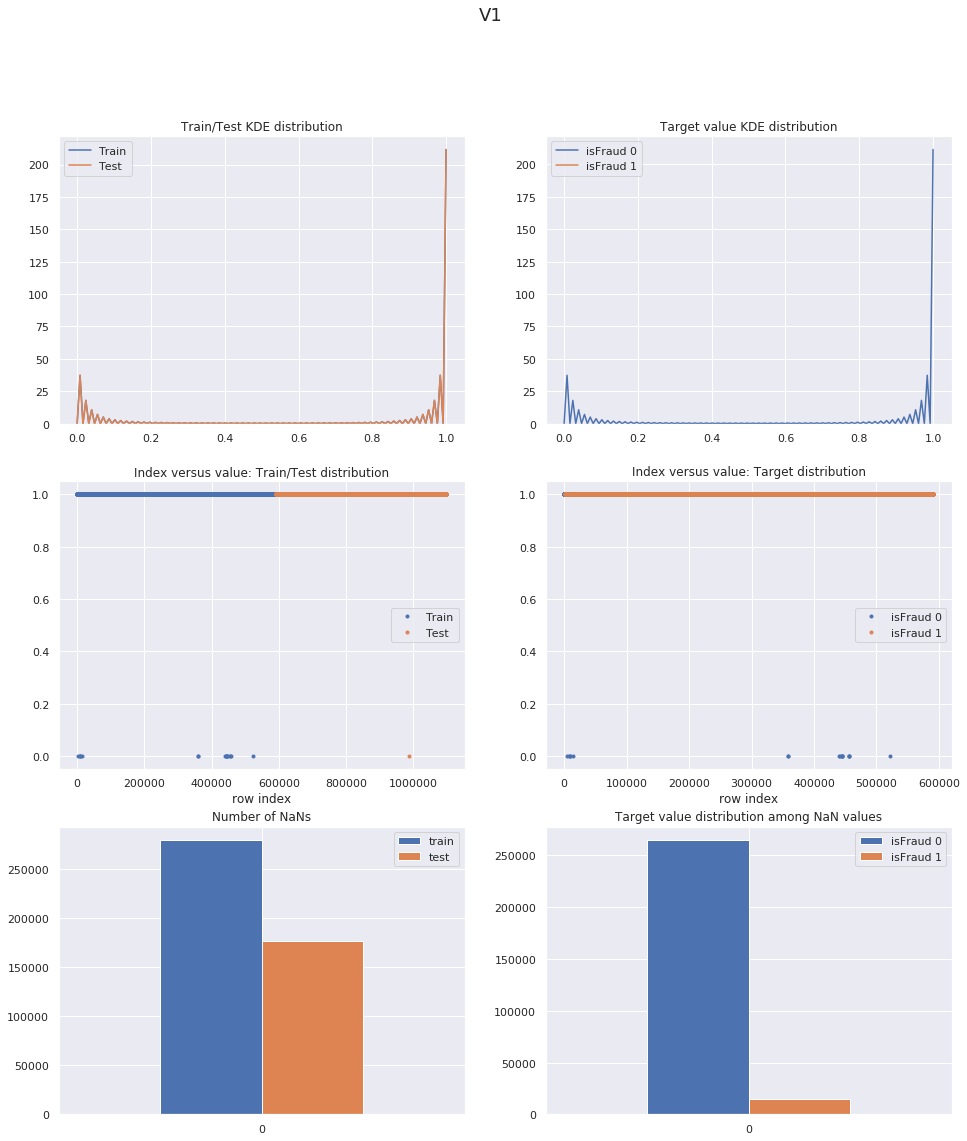

In [67]:
plot_numerical('V1')

In [68]:
print('Covariate shift:', covariate_shift('V1'))

Covariate shift: 0.5617312780270574


# V2

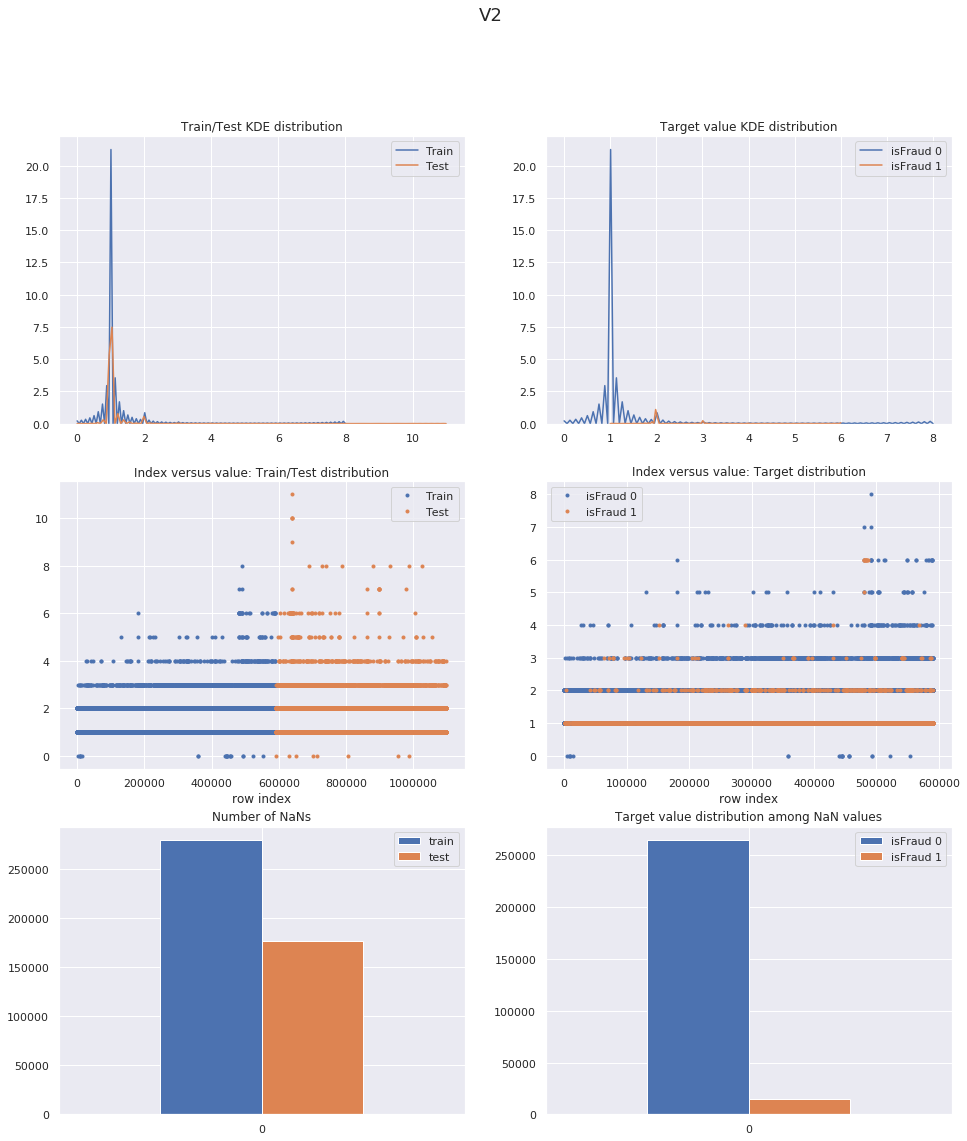

In [69]:
plot_numerical('V2')

In [70]:
print('Covariate shift:', covariate_shift('V2'))

Covariate shift: 0.561965049205892


# V3

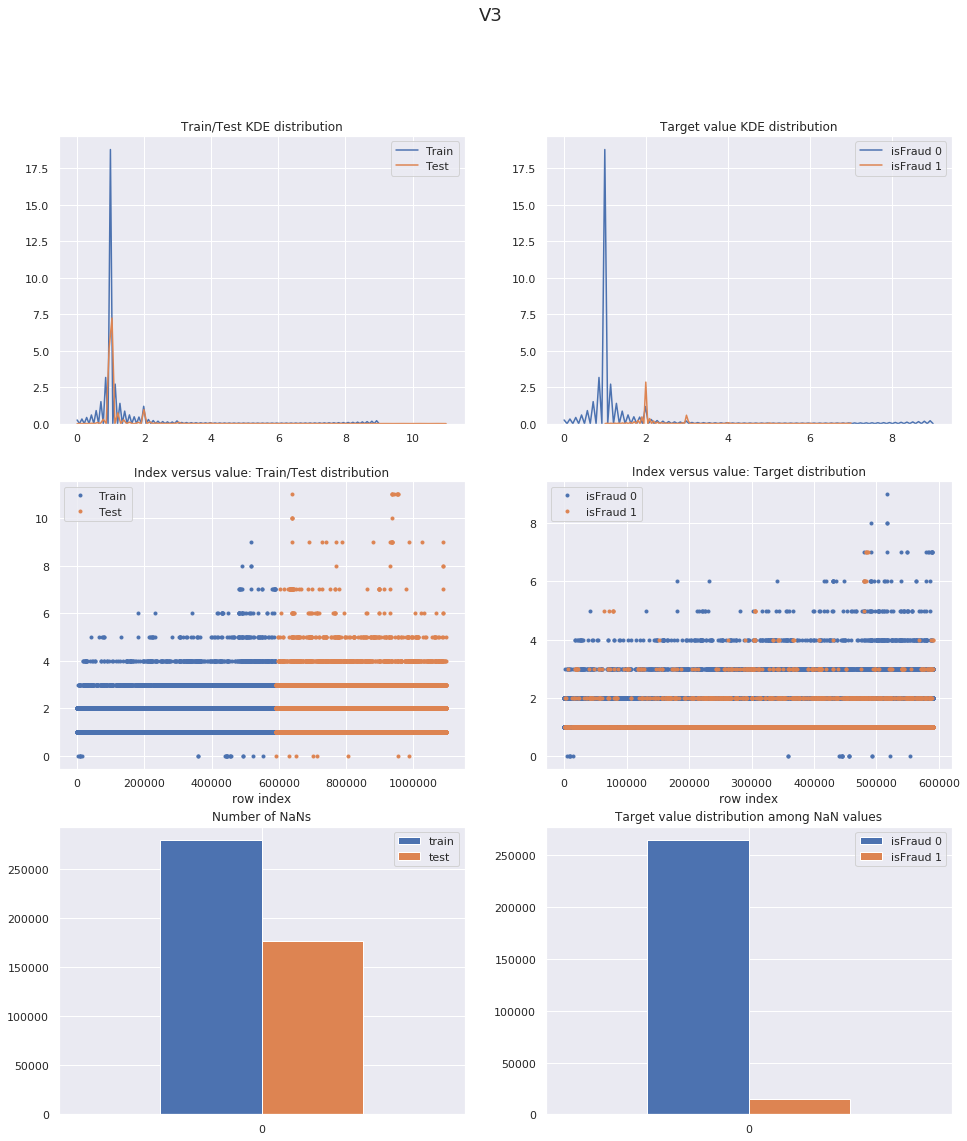

In [71]:
plot_numerical('V3')

In [72]:
print('Covariate shift:', covariate_shift('V3'))

Covariate shift: 0.5623831426057877


# V4

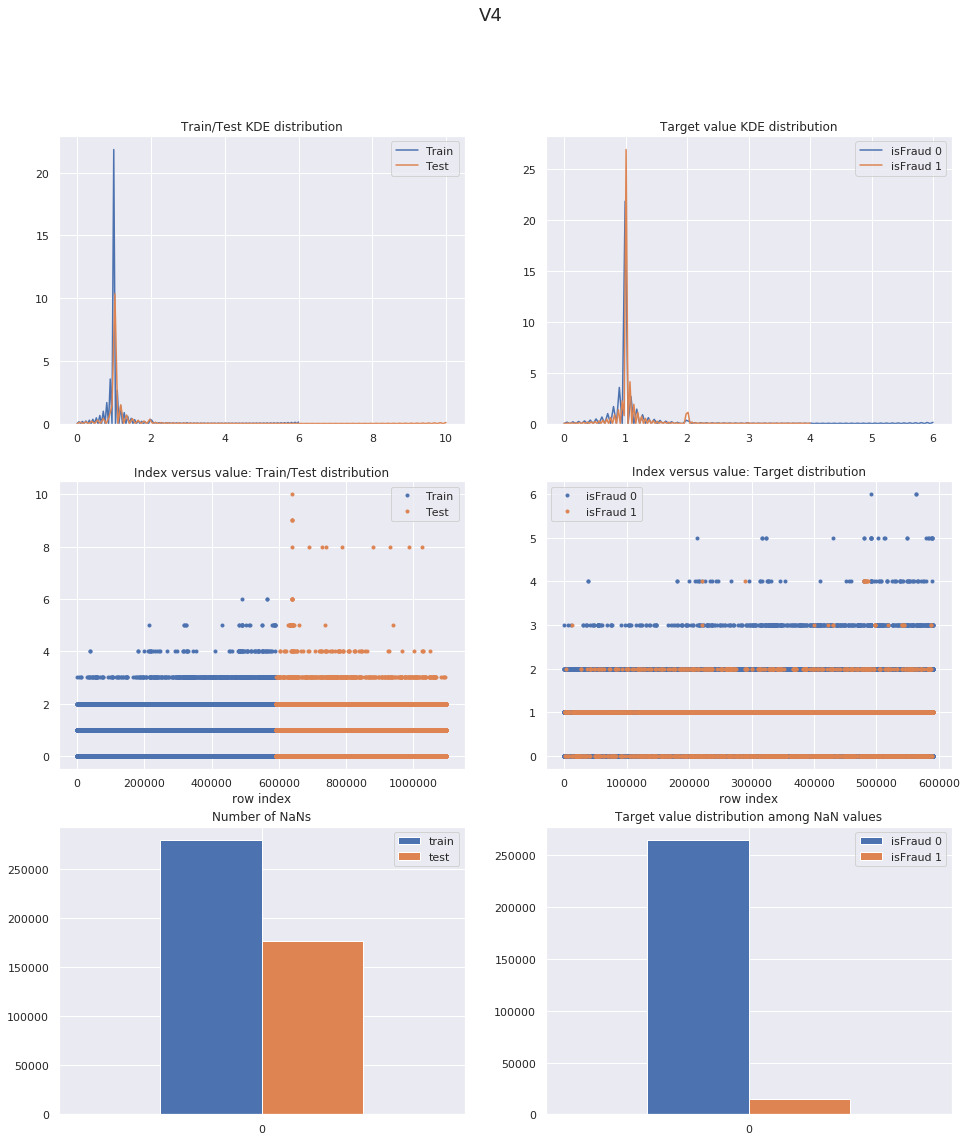

In [73]:
plot_numerical('V4')

In [74]:
print('Covariate shift:', covariate_shift('V4'))

Covariate shift: 0.563795271271095


# V5

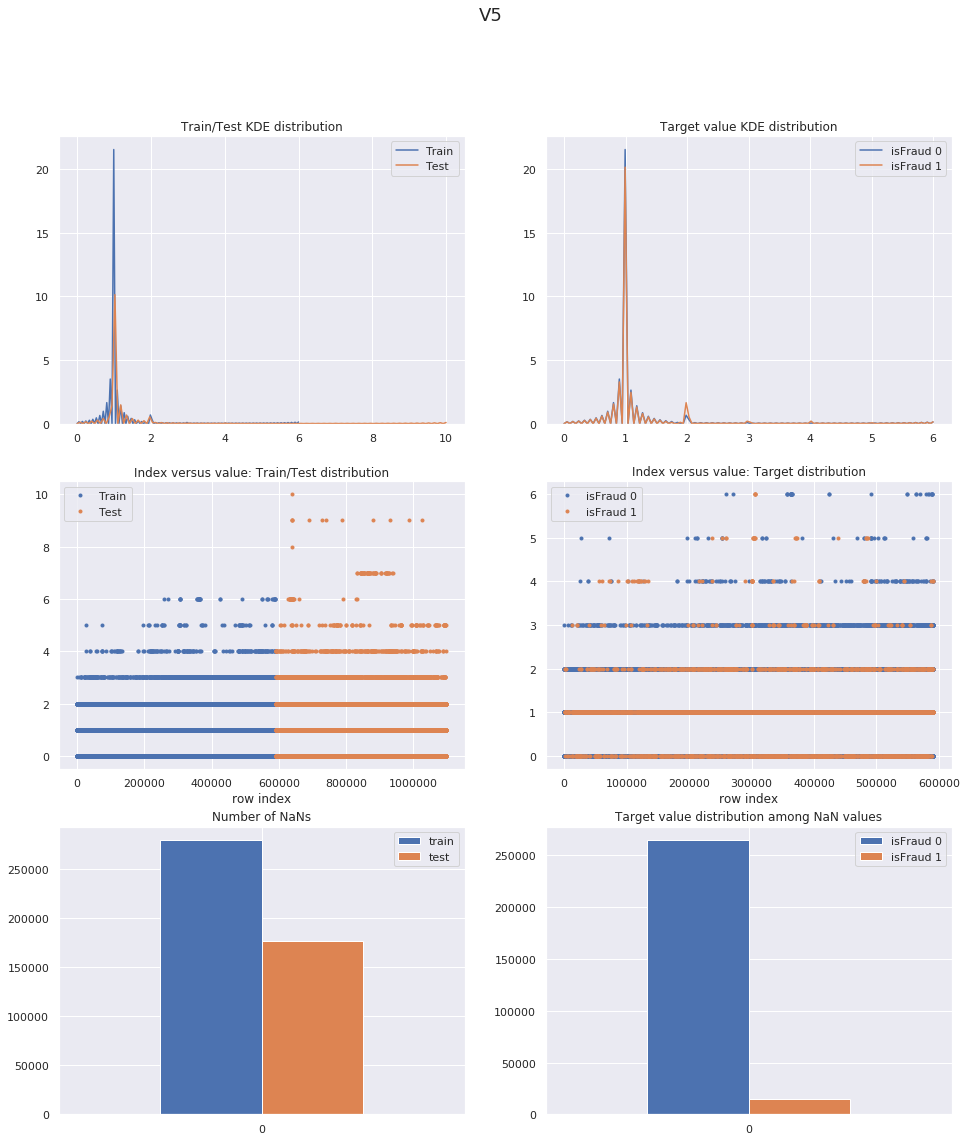

In [75]:
plot_numerical('V5')

In [76]:
print('Covariate shift:', covariate_shift('V5'))

Covariate shift: 0.5630419440028669


# V6

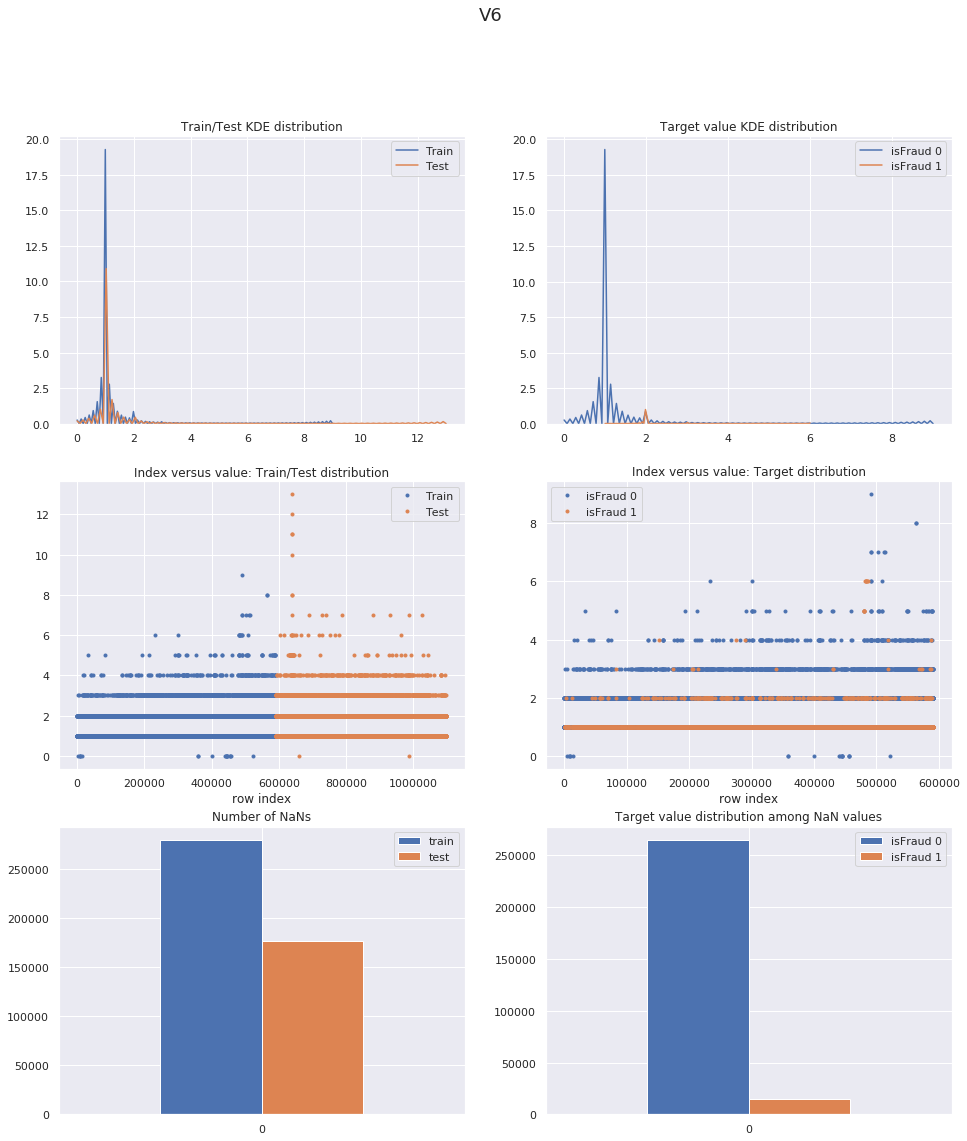

In [77]:
plot_numerical('V6')

In [78]:
print('Covariate shift:', covariate_shift('V6'))

Covariate shift: 0.5617925177822714


# V7

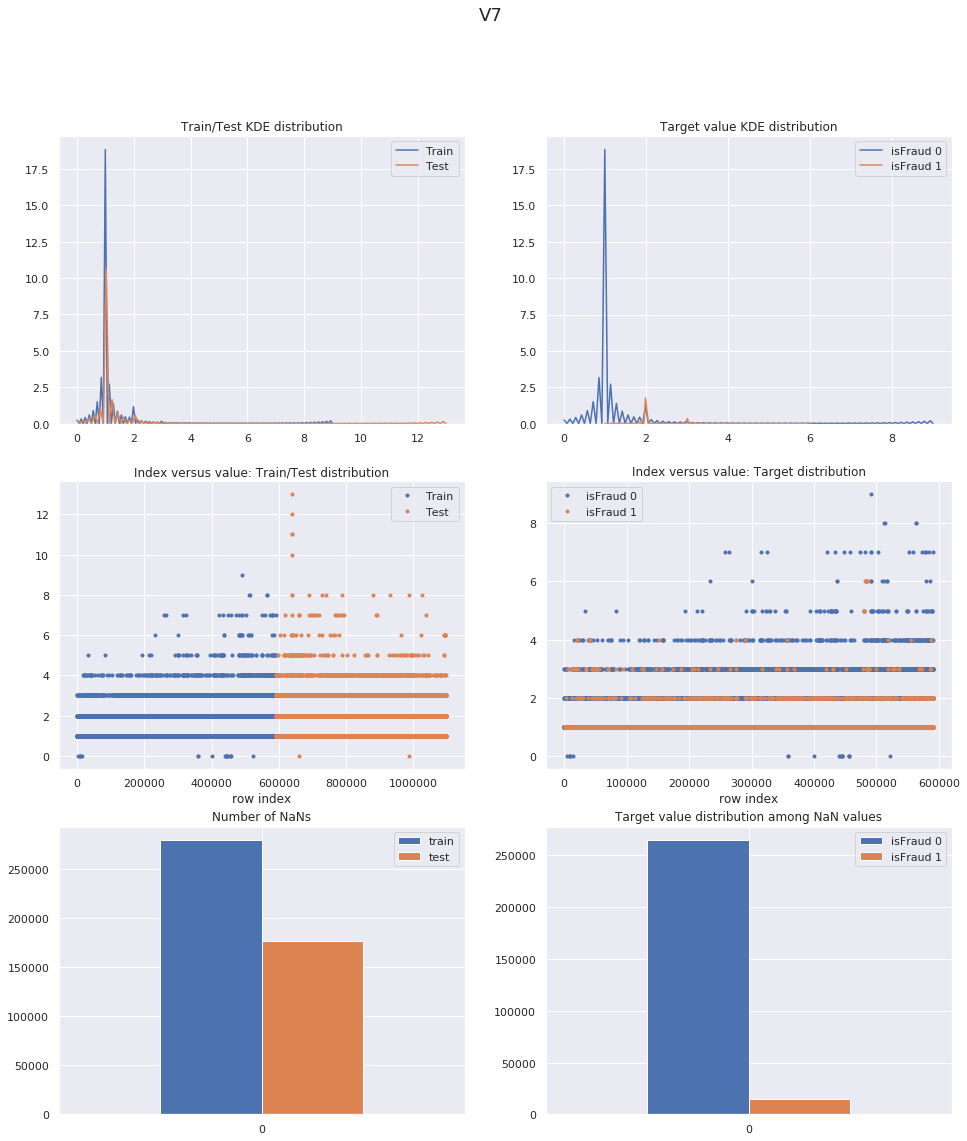

In [79]:
plot_numerical('V7')

In [80]:
print('Covariate shift:', covariate_shift('V7'))

Covariate shift: 0.5621310557757165


# V258

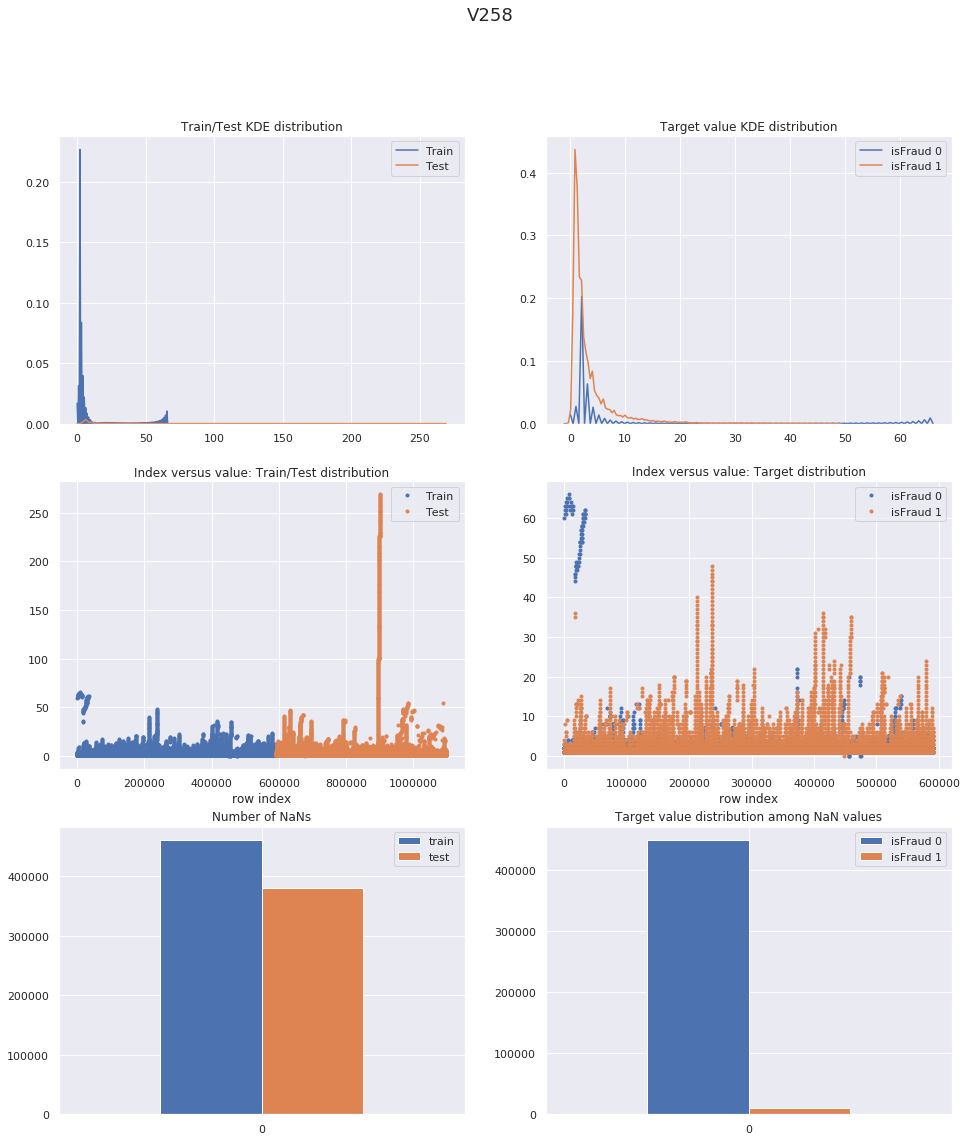

In [81]:
plot_numerical('V258')

In [82]:
print('Covariate shift:', covariate_shift('V258'))

Covariate shift: 0.5153350497369947


<a id="4"></a>
This is where I want to introduce a little trick to you, called data relaxation. So what is it? In order to understand it take a look at the plot above. See the distibution difference between train and test set at a certain point? Gradient boosting algorithm doesn't know what to do with a data it has never seen so it will not approximate it well. And what we do by relaxing data is we are removing all the values from the train set that appears in it 3 times more often than in a test set and vice versa, also cleaning all the data that appears in train and test set only couple of times.

## V258 after data relaxation

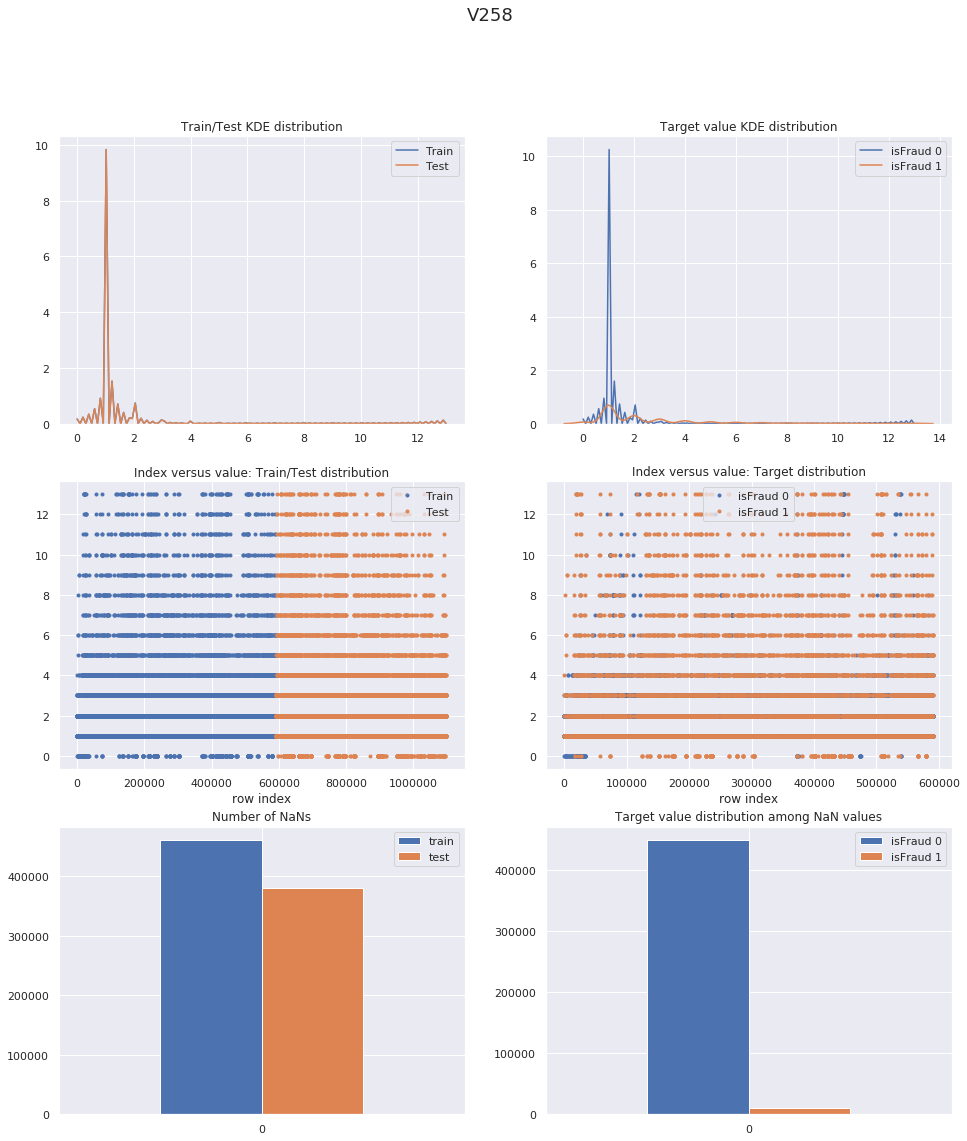

In [83]:
train, test = relax_data(train, test, 'V258')
plot_numerical('V258')

# V294

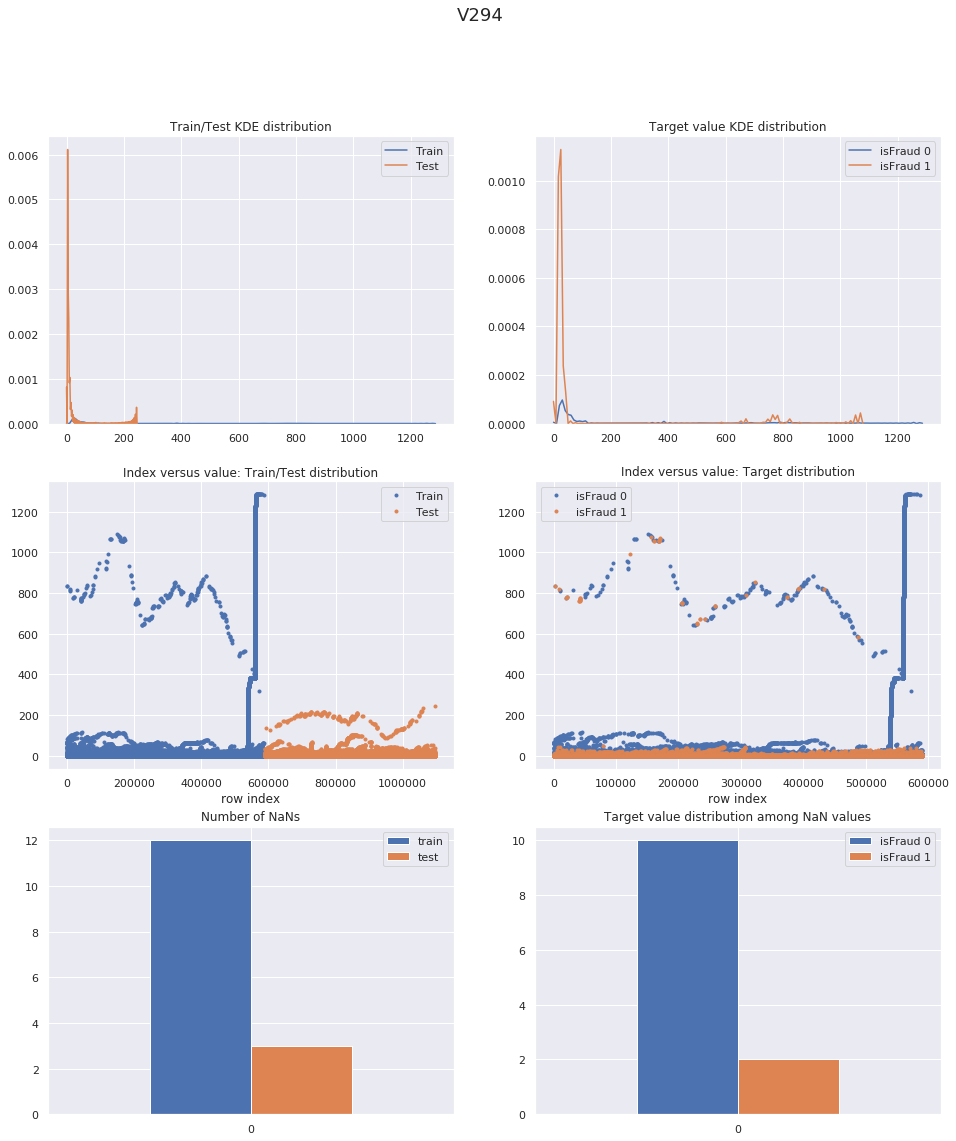

In [84]:
plot_numerical('V294')

In [85]:
print('Covariate shift:', covariate_shift('V294'))

Covariate shift: 0.5073842432471619


## V294 after data relaxation

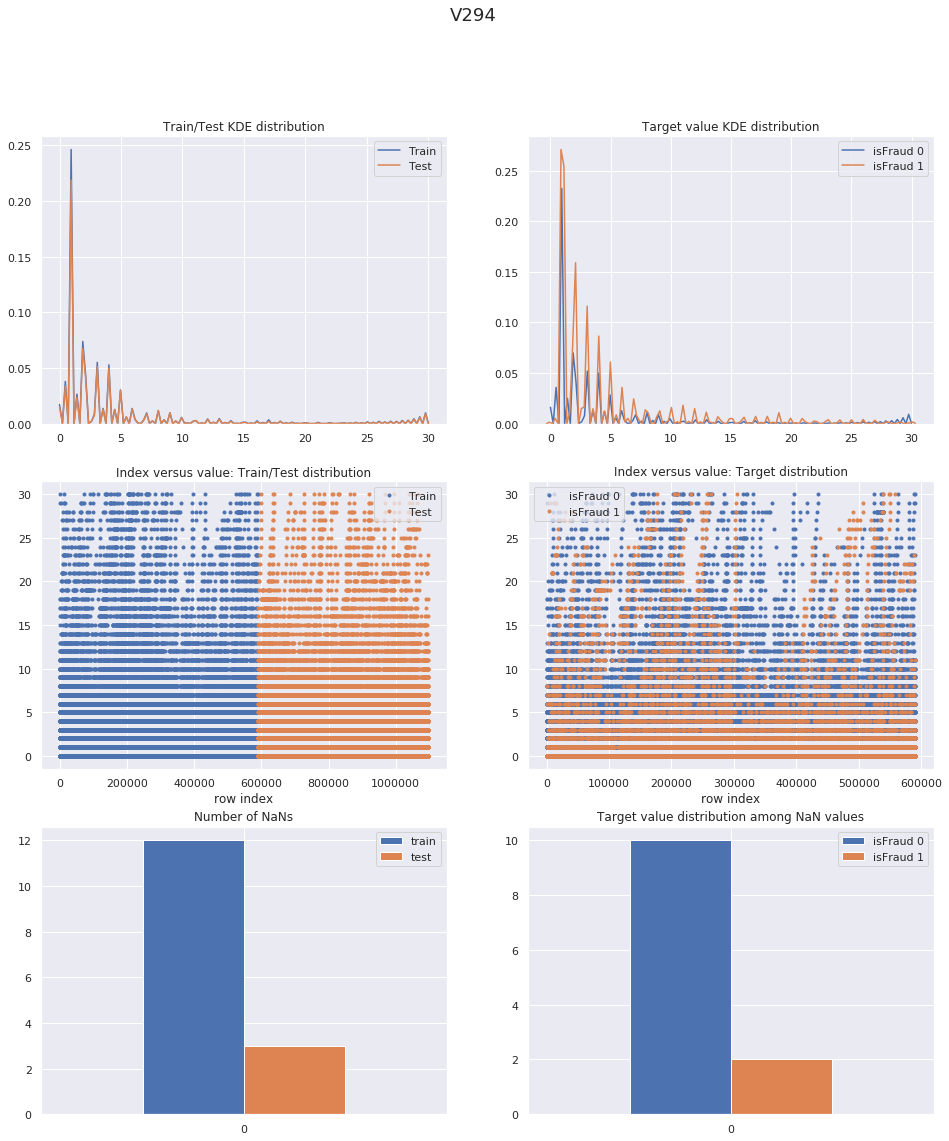

In [86]:
train, test = relax_data(train, test, 'V294')
plot_numerical('V294')

# C1

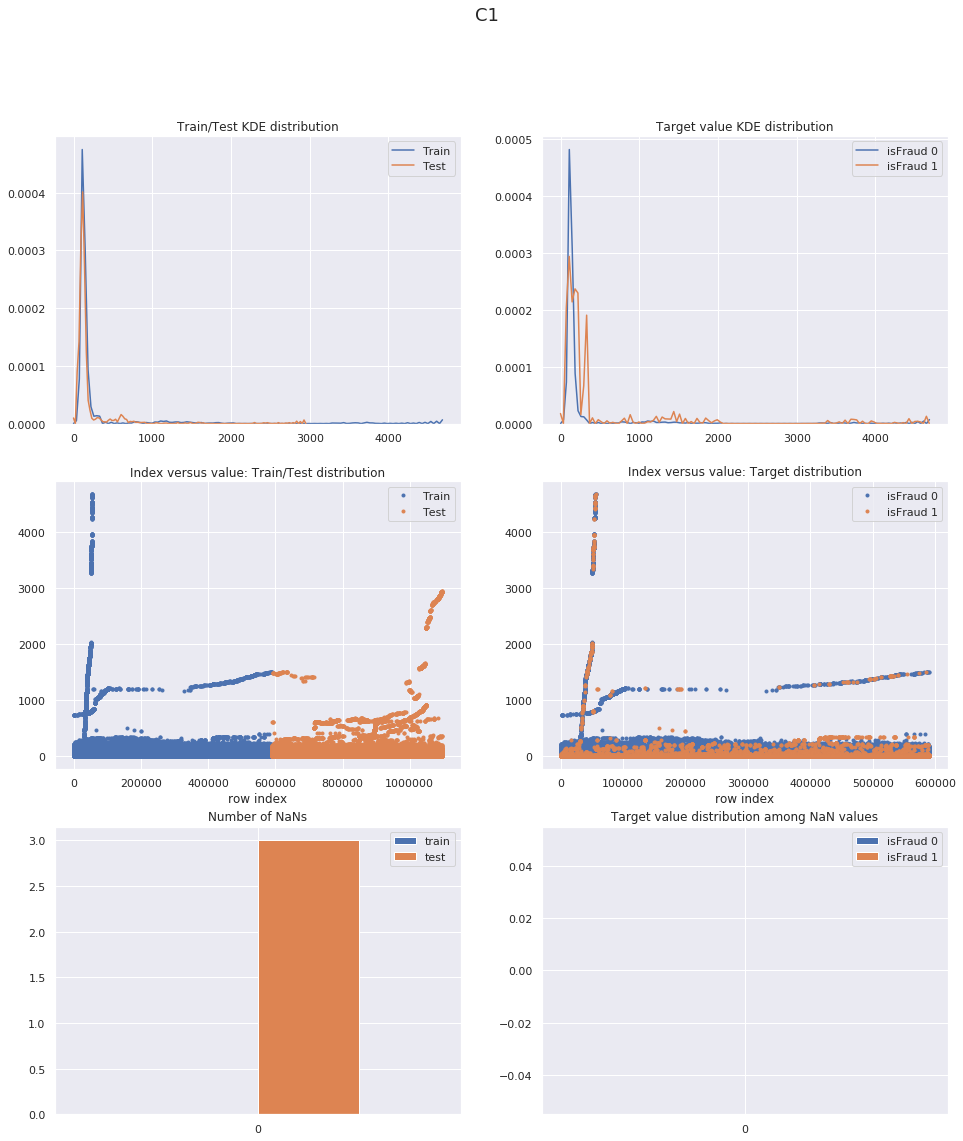

In [87]:
plot_numerical('C1')

In [88]:
print('Covariate shift:', covariate_shift('C1'))

Covariate shift: 0.5181248850570104


## C1 after data relaxation

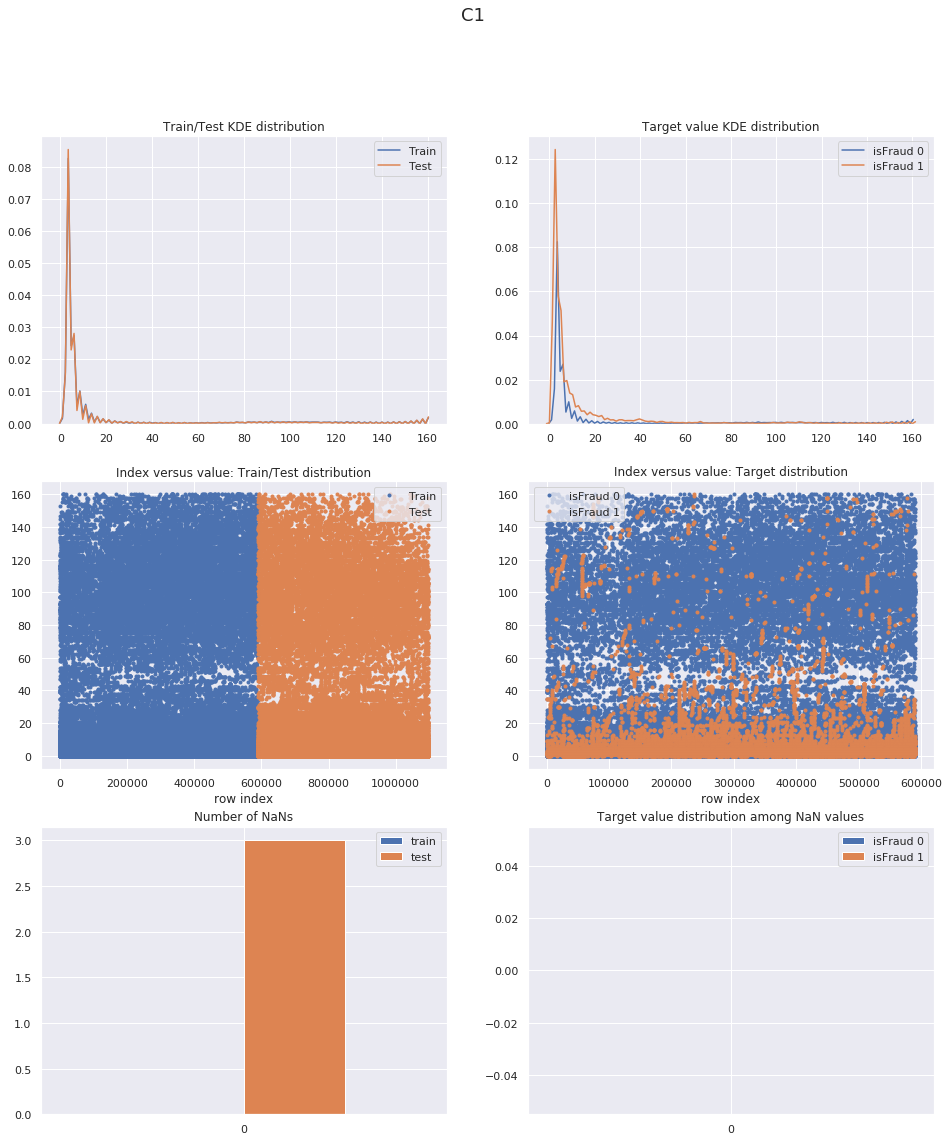

In [89]:
train, test = relax_data(train, test, 'C1')
plot_numerical('C1')

# C2

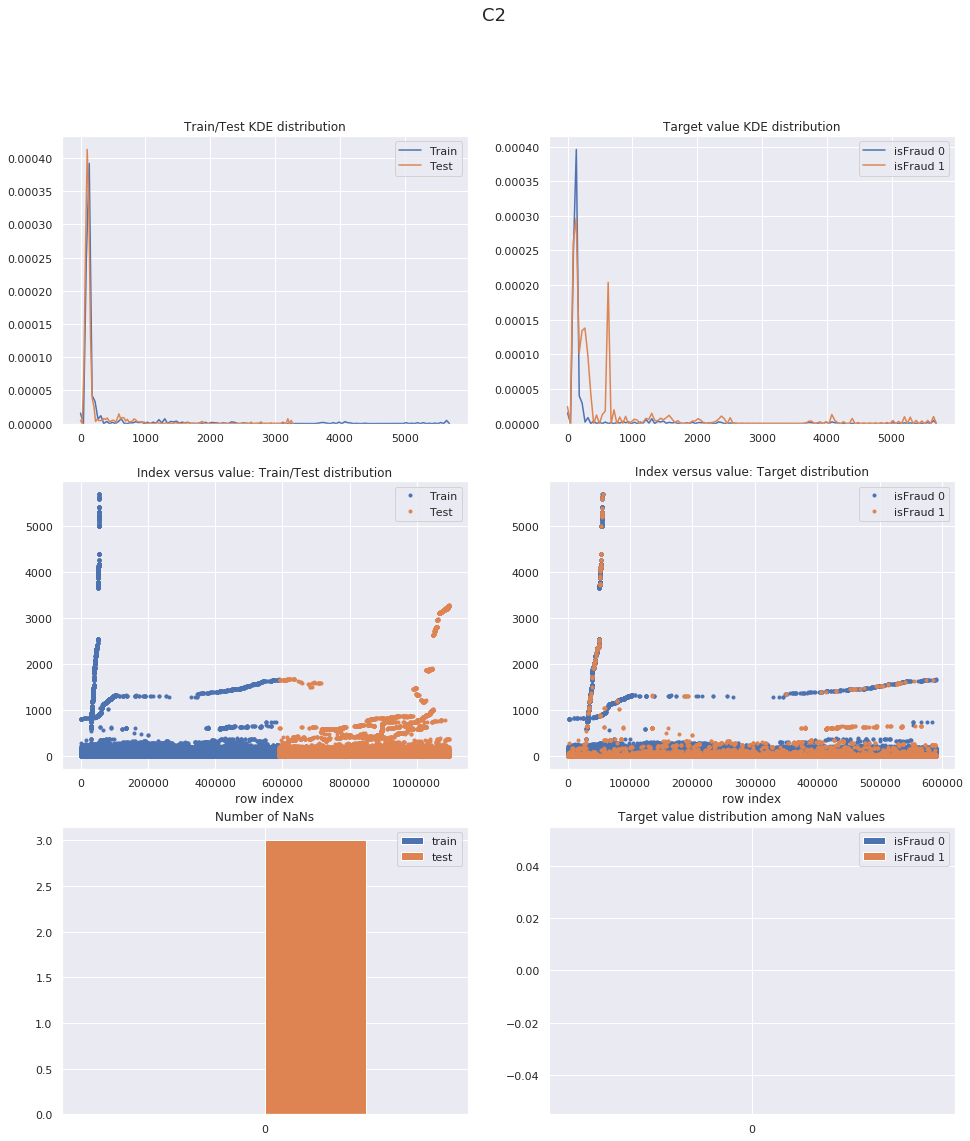

In [90]:
plot_numerical('C2')

In [91]:
print('Covariate shift:', covariate_shift('C2'))

Covariate shift: 0.518648419532034


## C2 after data relaxation.

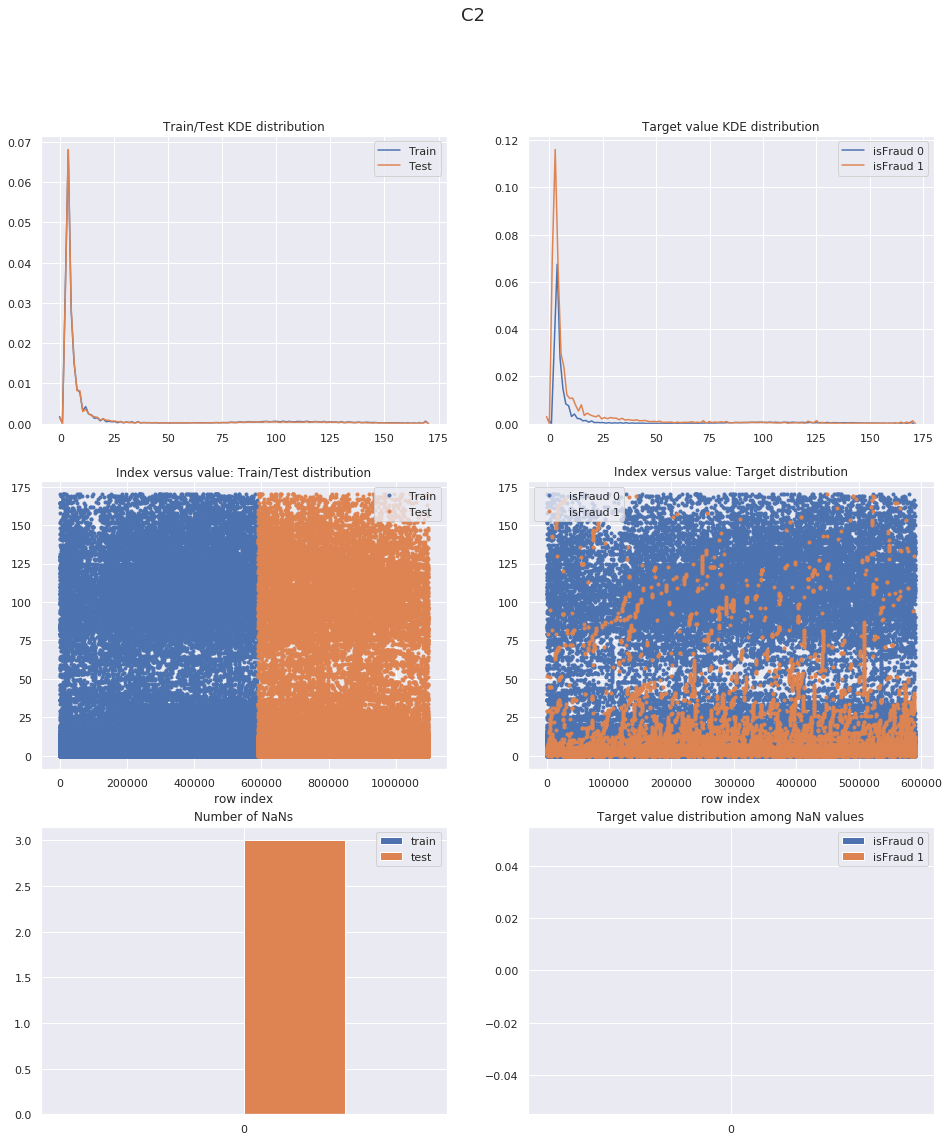

In [92]:
train, test = relax_data(train, test, 'C2')
plot_numerical('C2')

In [93]:
print('Covariate shift after data relaxation:', covariate_shift('C2'))

Covariate shift after data relaxation: 0.5144525338191479


# C3

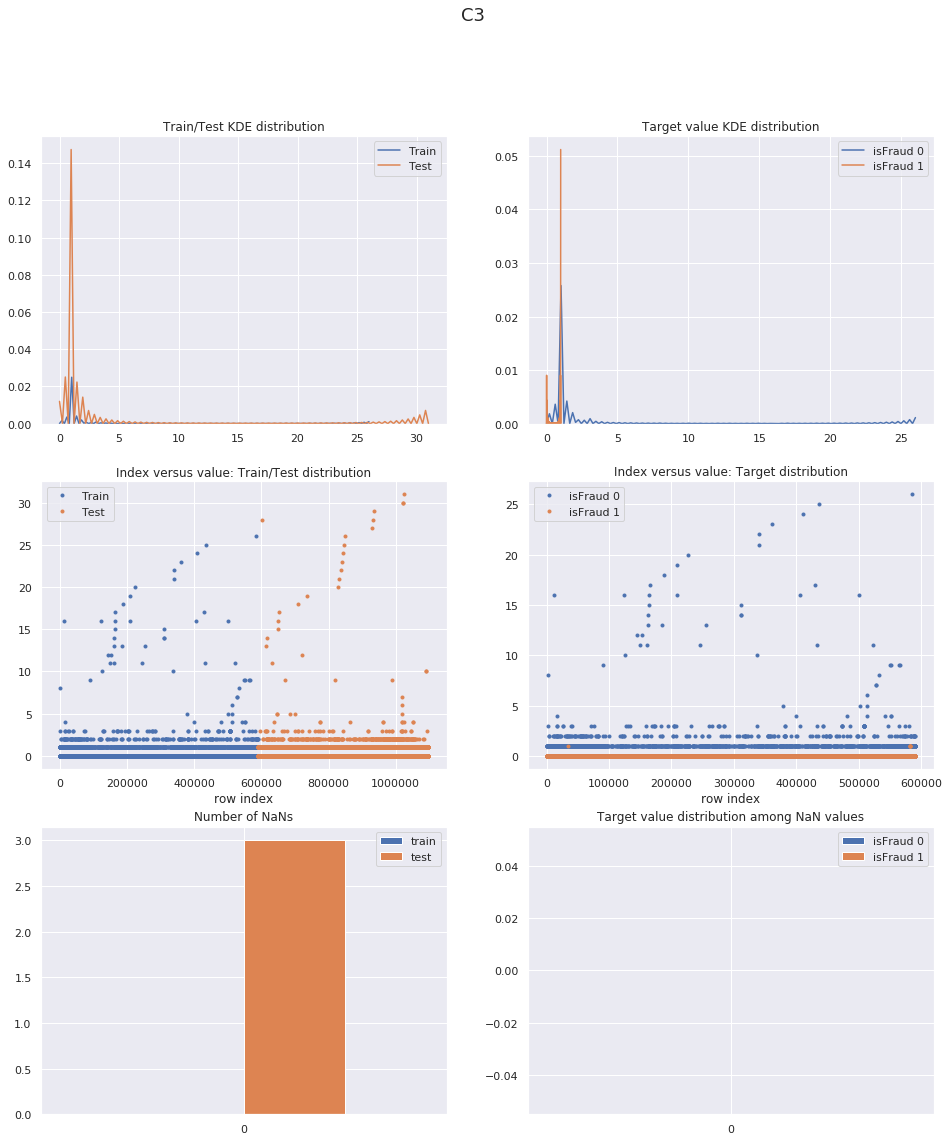

In [94]:
plot_numerical('C3')

In [95]:
print('Covariate shift:', covariate_shift('C3'))

Covariate shift: 0.5107250988635688


## C3 after data relaxation

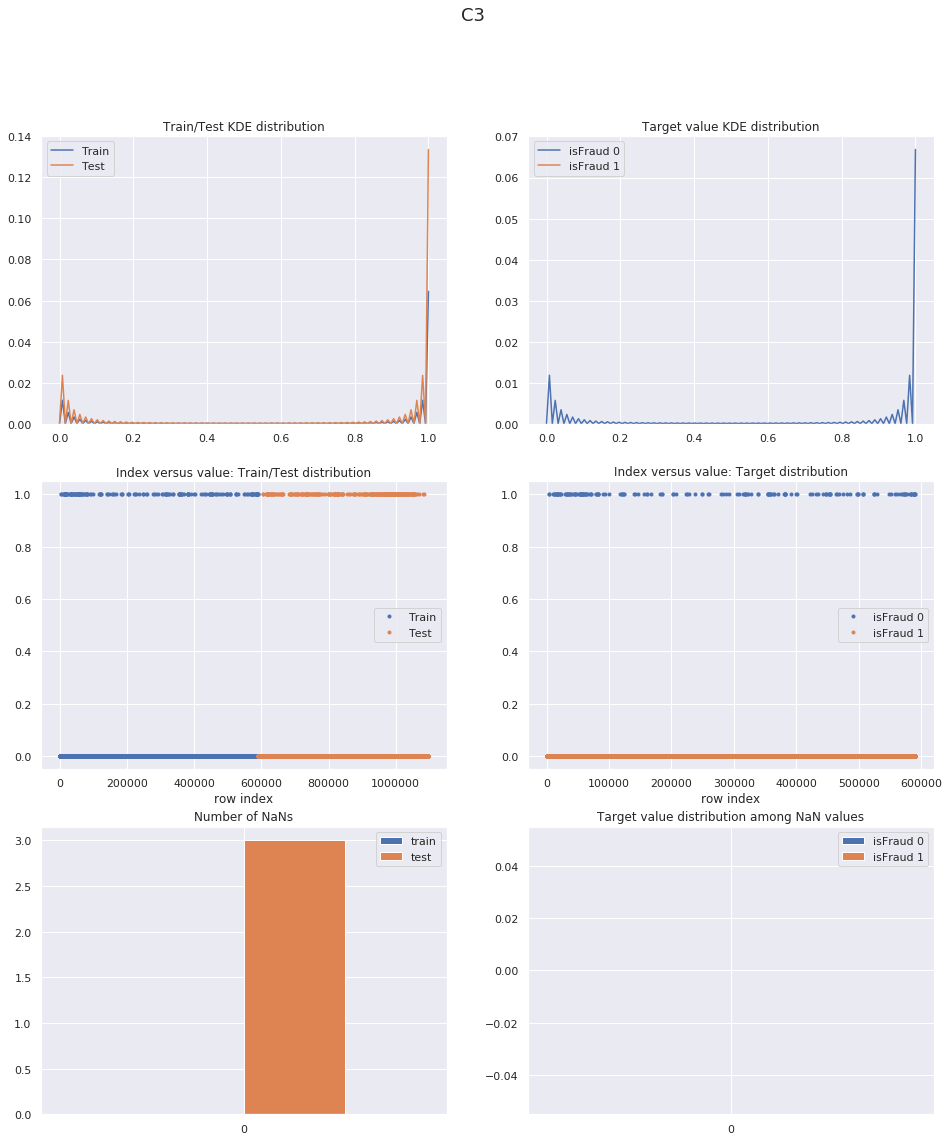

In [96]:
train, test = relax_data(train, test, 'C3')
plot_numerical('C3')

In [97]:
print('Covariate shift after data relaxation:', covariate_shift('C3'))

Covariate shift after data relaxation: 0.5001801231225987


# C4

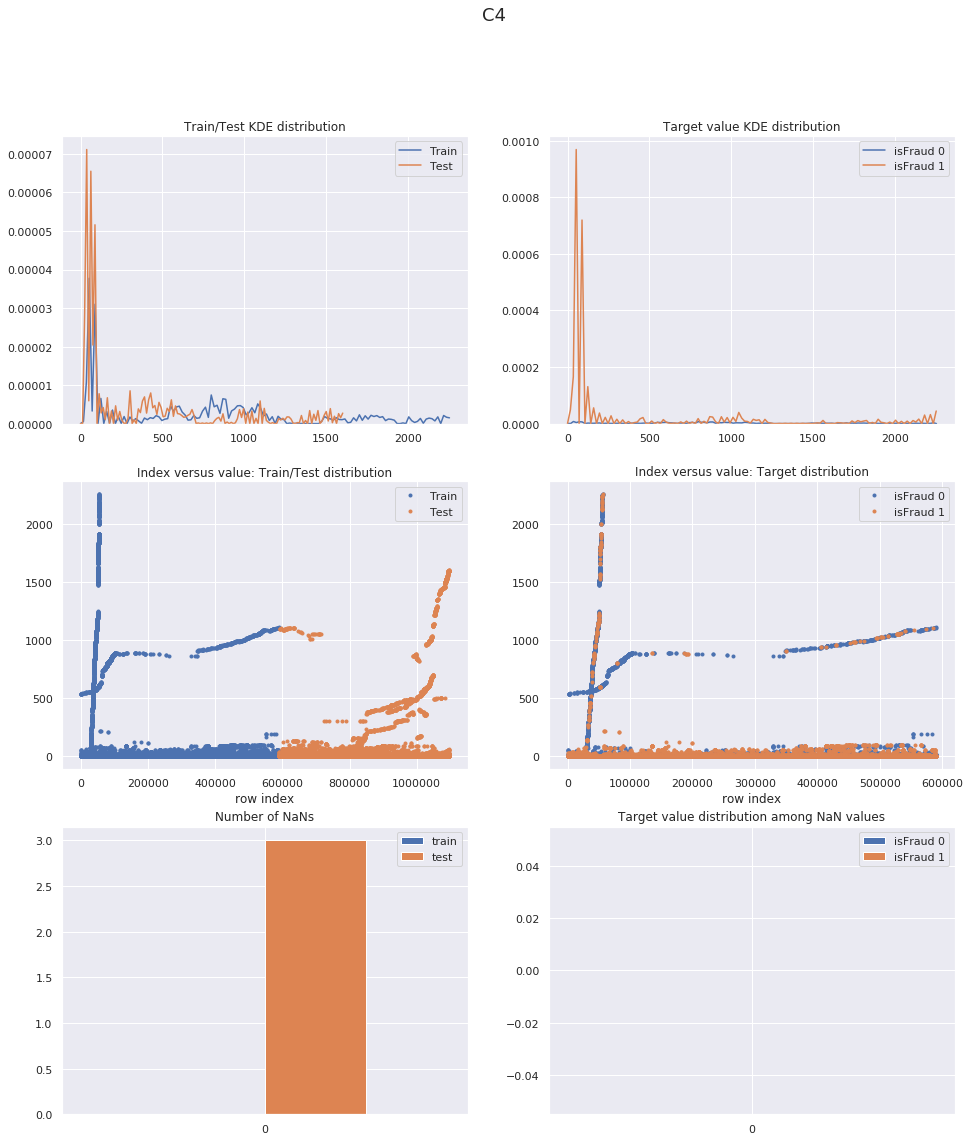

In [98]:
plot_numerical('C4')

In [99]:
print('Covariate shift:', covariate_shift('C4'))

Covariate shift: 0.5195500902671415


## C4 after data relaxation

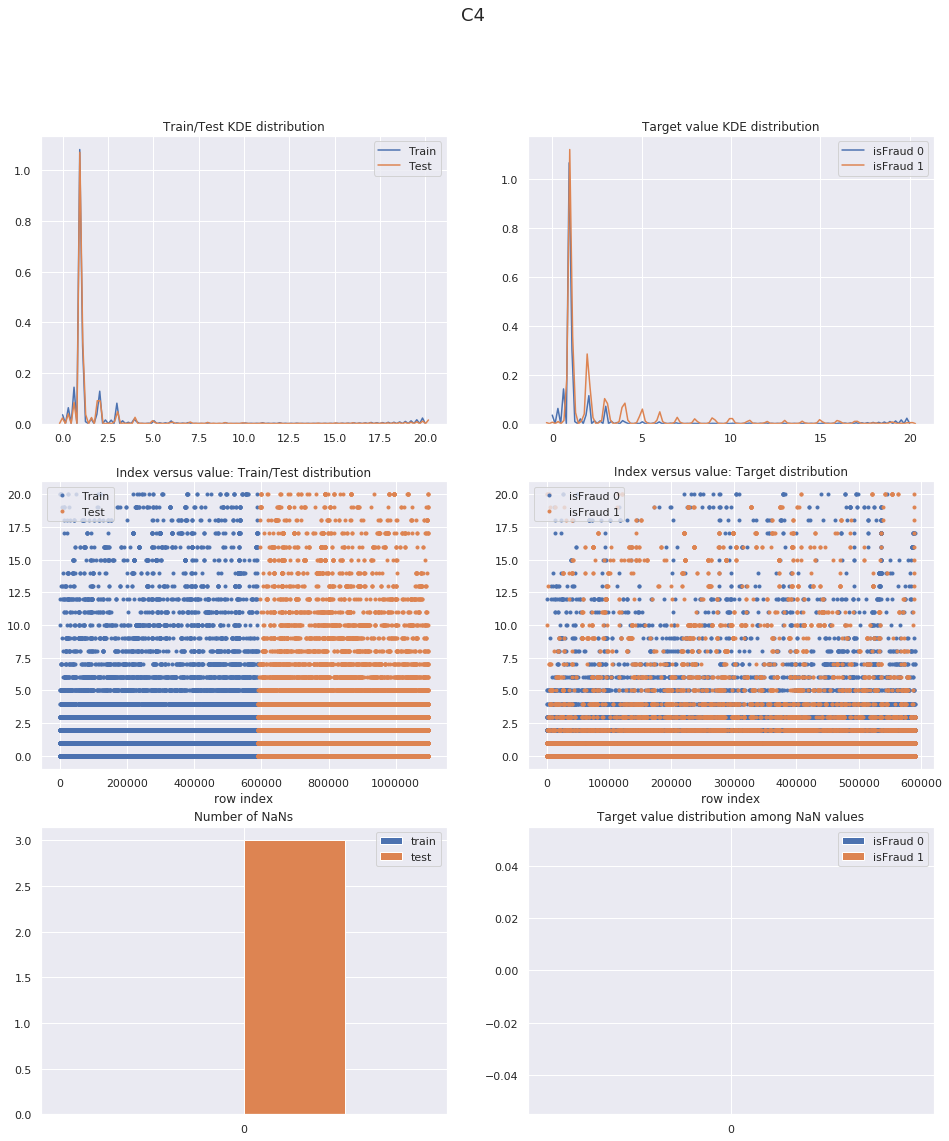

In [100]:
train, test = relax_data(train, test, 'C4')
plot_numerical('C4')

In [101]:
print('Covariate shift after data relaxation:', covariate_shift('C4'))

Covariate shift after data relaxation: 0.5169405765179351


# C5

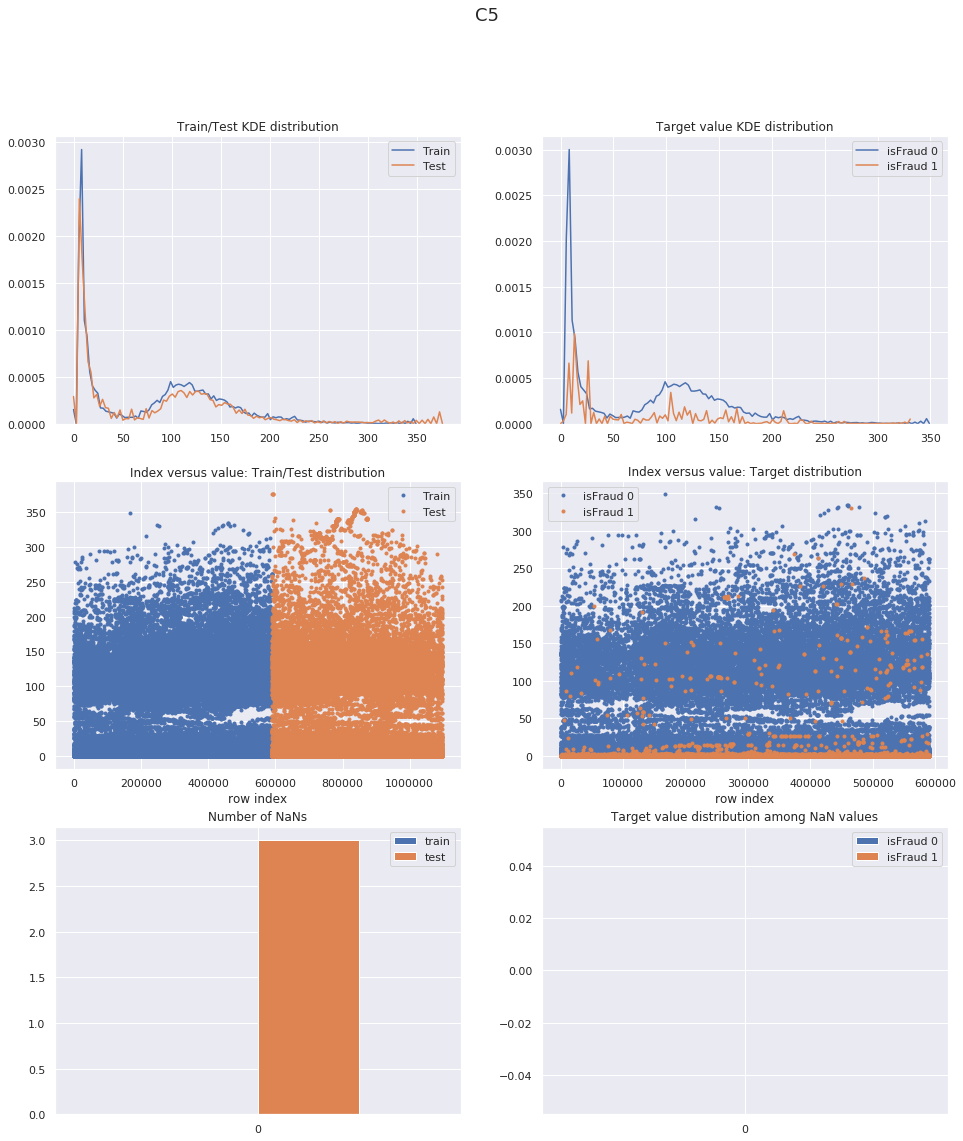

In [102]:
plot_numerical('C5')

In [103]:
print('Covariate shift:', covariate_shift('C5'))

Covariate shift: 0.5186088713799747


## C5 after data relaxation

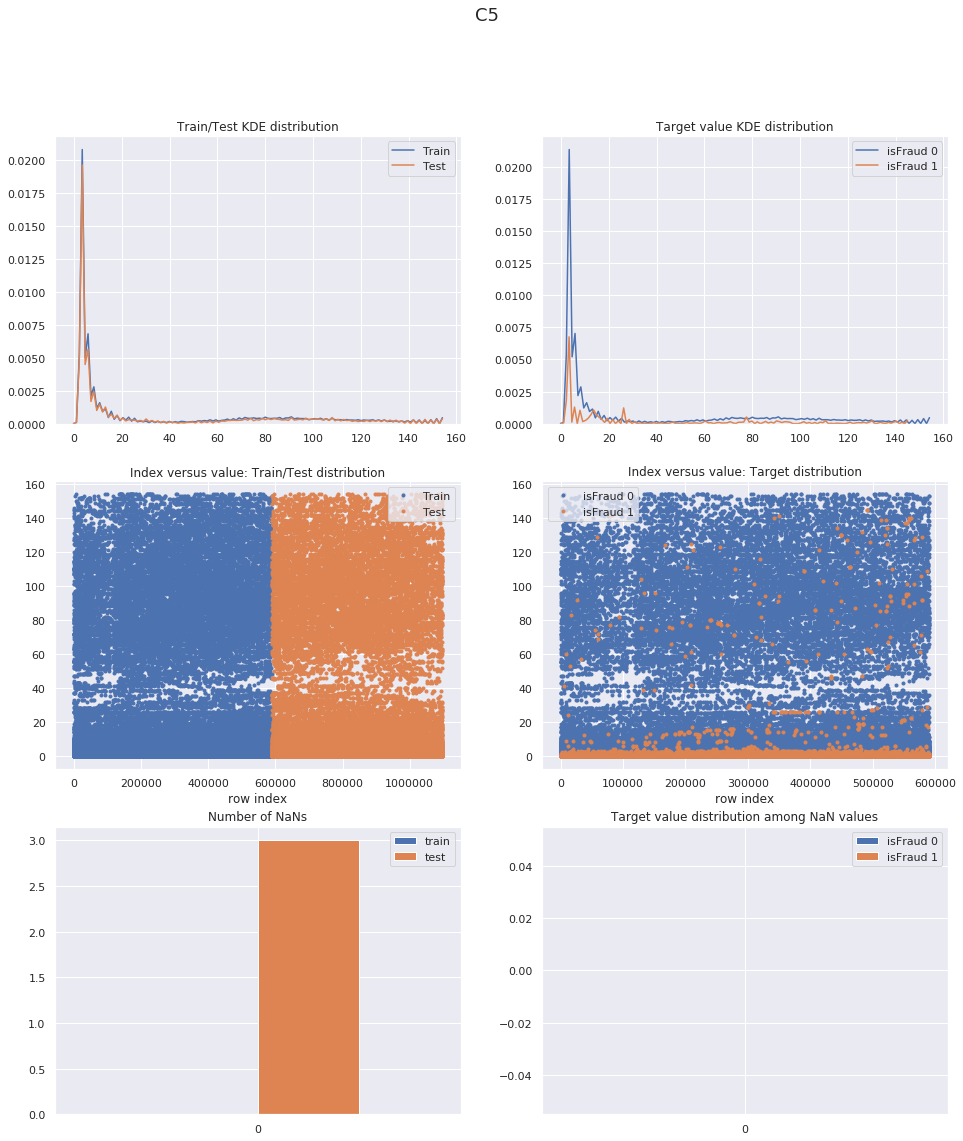

In [104]:
train, test = relax_data(train, test, 'C5')
plot_numerical('C5')

In [105]:
print('Covariate shift after data relaxation:', covariate_shift('C5'))

Covariate shift after data relaxation: 0.5173163167610019


# C6

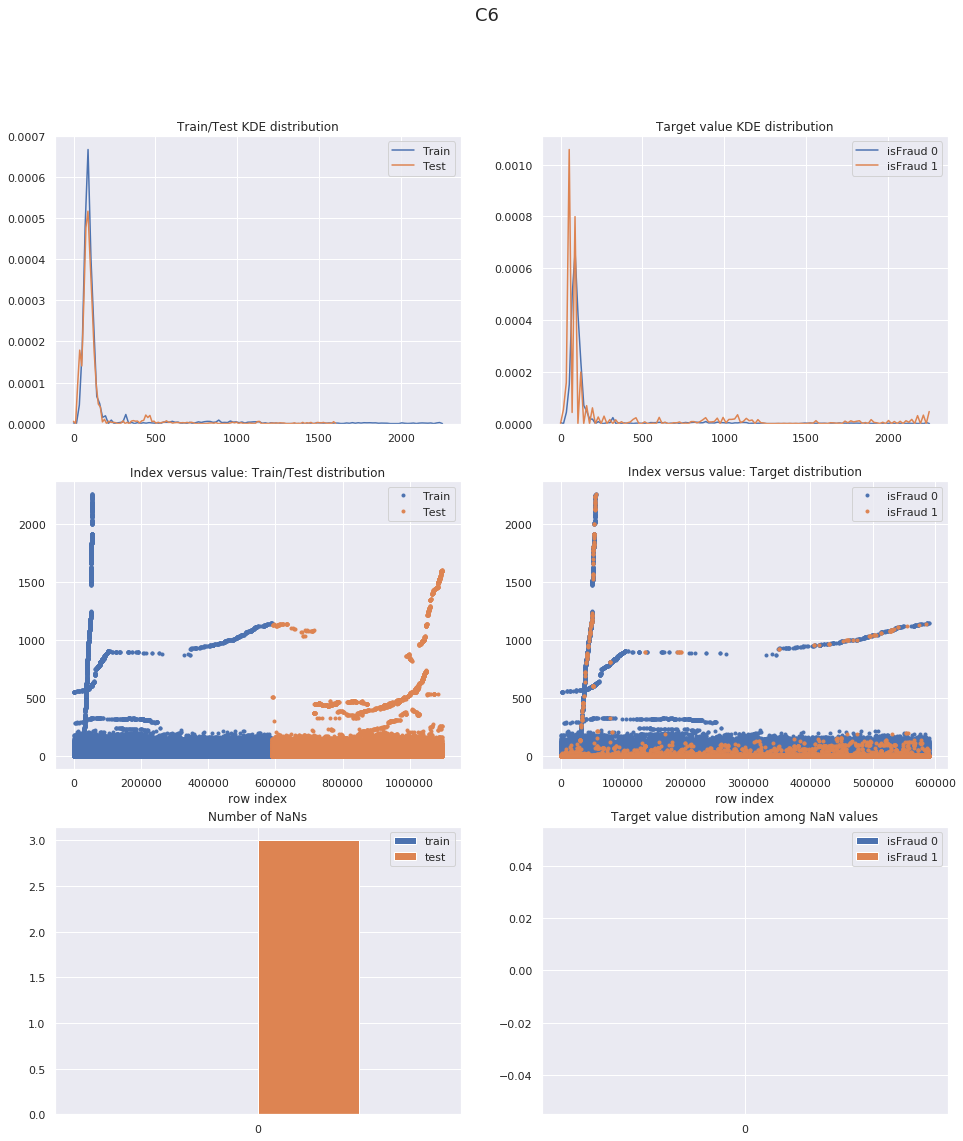

In [106]:
plot_numerical('C6')

In [107]:
print('Covariate shift:', covariate_shift('C6'))

Covariate shift: 0.5140069478003465


## C6 after data relaxation

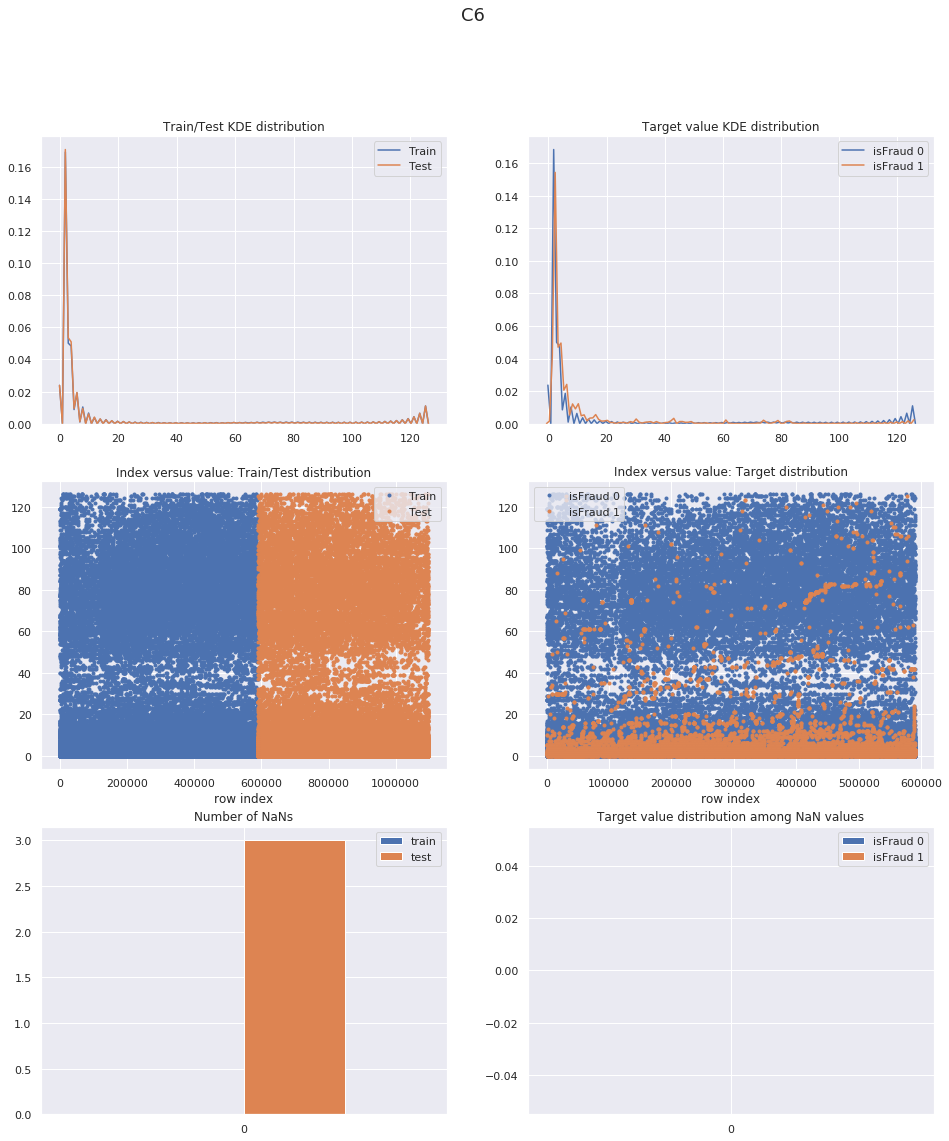

In [108]:
train, test = relax_data(train, test, 'C6')
plot_numerical('C6')

In [109]:
print('Covariate shift after data relaxation:', covariate_shift('C6'))

Covariate shift after data relaxation: 0.5114996618242401


# C7

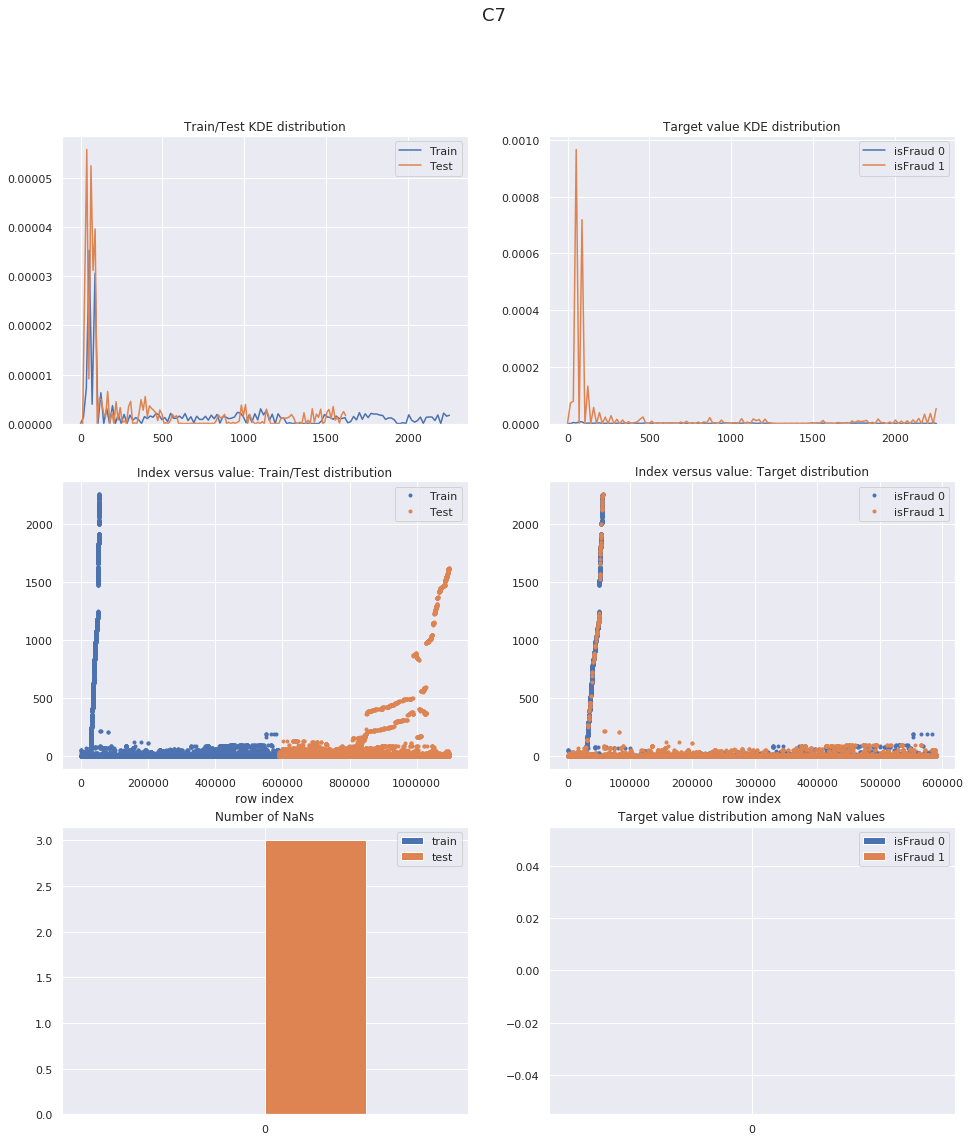

In [110]:
plot_numerical('C7')

In [111]:
print('Covariate shift:', covariate_shift('C7'))

Covariate shift: 0.5132035889808506


## C7 after data relaxation

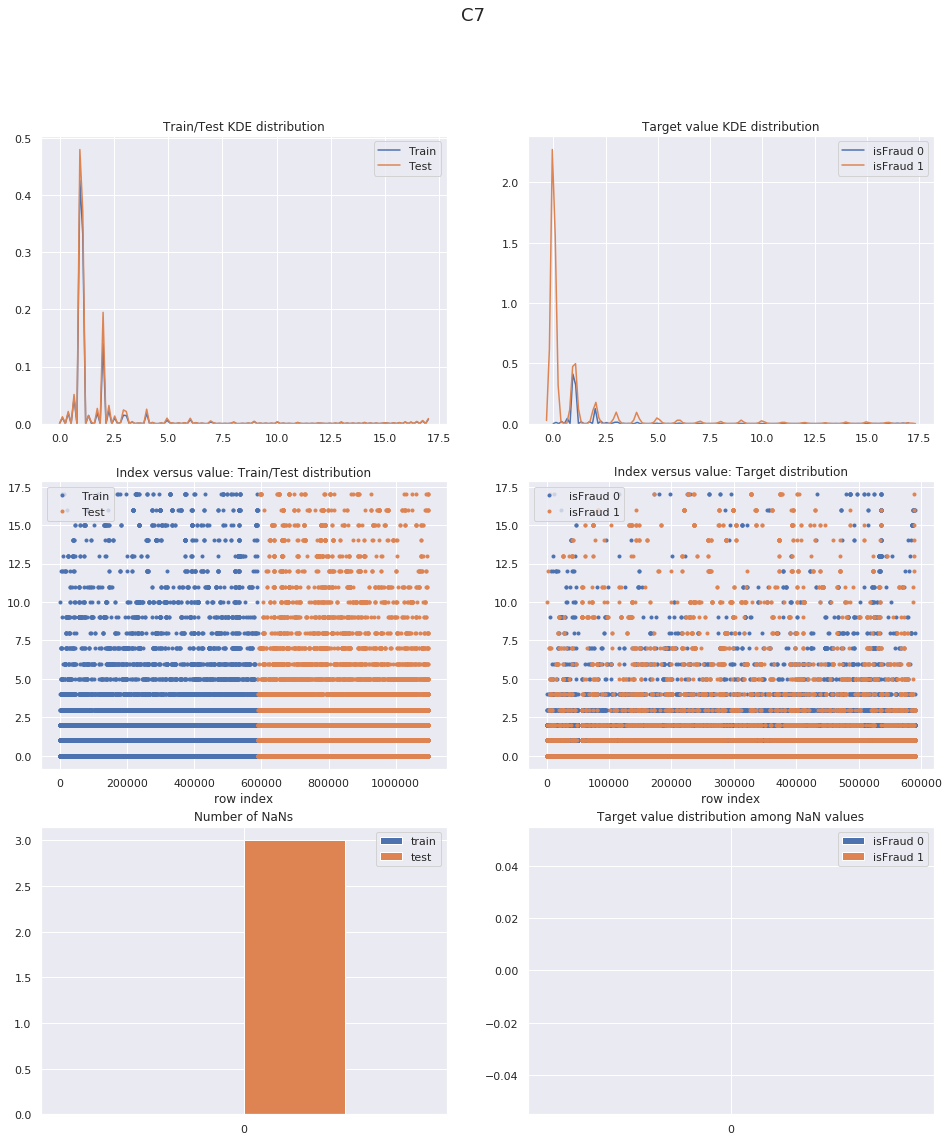

In [112]:
train, test = relax_data(train, test, 'C7')
plot_numerical('C7')

In [113]:
print('Covariate shift after data relaxation:', covariate_shift('C7'))

Covariate shift after data relaxation: 0.5106763918808377


# C13

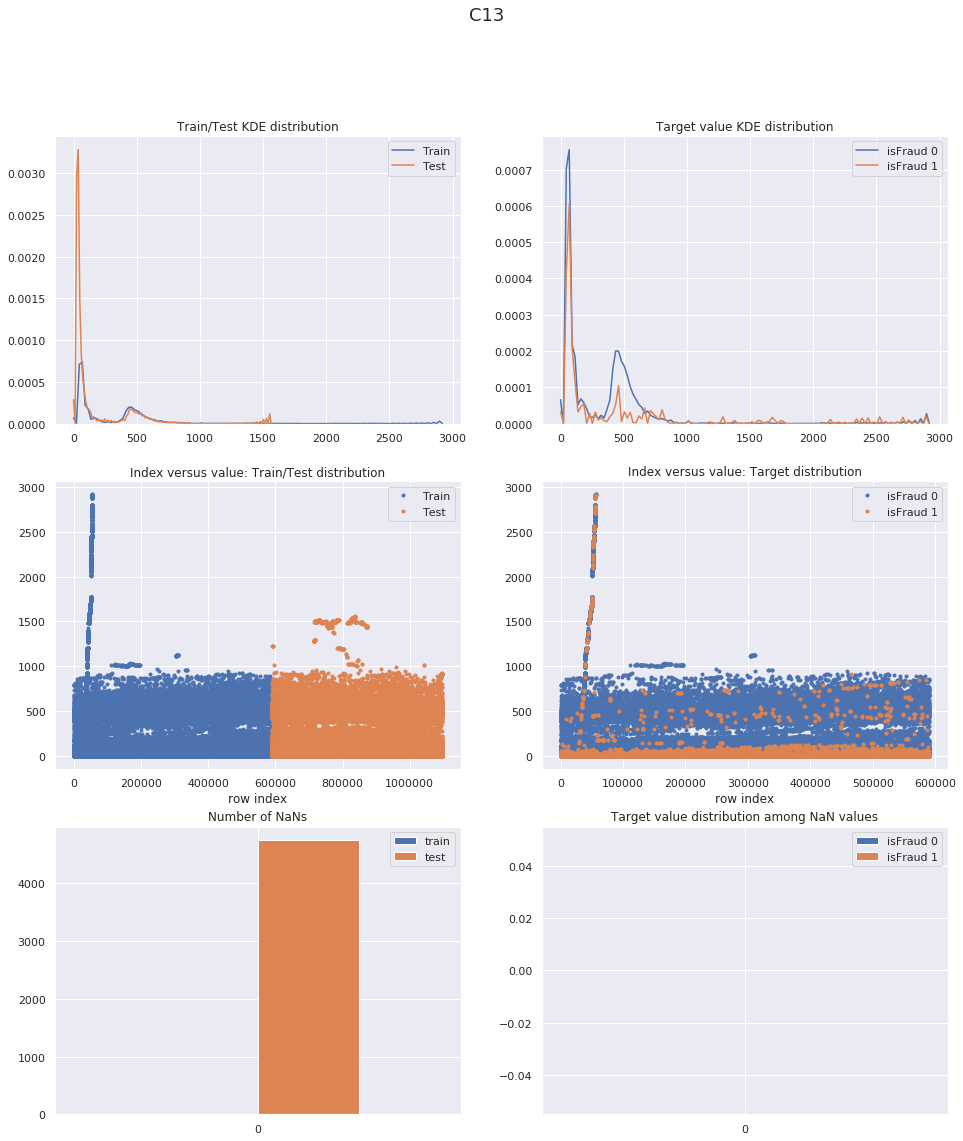

In [114]:
plot_numerical('C13')

# C14

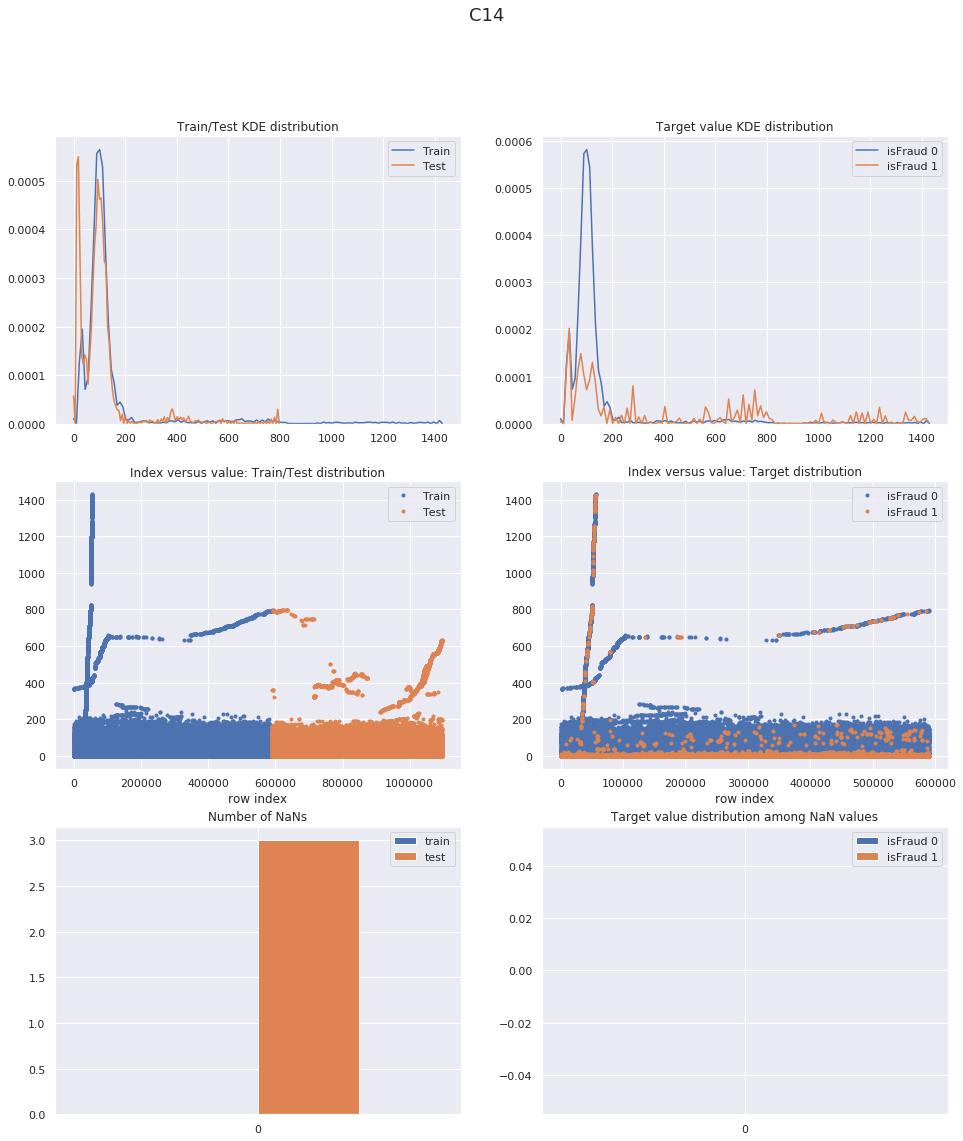

In [115]:
plot_numerical('C14')

# id_31

In [116]:
print('Covariate shift:', covariate_shift('id_31'))

Covariate shift: 0.6812747910333805
